## Latar Belakang Analisis NYC TLC Trip Records

New York City Taxi and Limousine Commission (NYC TLC) adalah badan regulasi yang dibentuk pada tahun 1971 dan bertanggung jawab untuk mengawasi dan mengatur industri transportasi untuk-sewa di New York City. Lembaga ini mengatur berbagai layanan transportasi termasuk taksi medallion (taksi kuning), street hail liveries (taksi hijau), for-hire vehicles (FHV), paratransit vehicles, dan commuter vans.
Sebagai bagian dari upaya modernisasi dan peningkatan layanan, NYC TLC mengimplementasikan sistem Livery Passenger Enhancement Program (LPEP) untuk taksi hijau. Sistem ini dioperasikan oleh dua vendor teknologi:

- Creative Mobile Technologies (CMT)

    - Penyedia teknologi transportasi yang fokus pada payment processing
    - Menyediakan sistem in-taxi entertainment dan digital advertising
    - Telah merger dengan Curb Mobility pada tahun 2022


- VeriFone Systems

    - Perusahaan teknologi pembayaran global
    - Menyediakan solusi pembayaran dan manajemen armada untuk industri taksi
    - Mengoperasikan sistem LPEP untuk sebagian armada taksi NYC



# Identifikasi Masalah Awal
Dalam proses analisis awal data trip records, terdapat beberapa temuan yang menjadi perhatian:

- Anomali Pembayaran

    - Ditemukan transaksi dengan total amount negatif
    - Terdapat improvement surcharge yang bernilai 0 (seharusnya minimal $0.30)
    - MTA tax missing pada beberapa transaksi (seharusnya $0.50)


- Masalah Pencatatan Trip

    - Trip dengan durasi sangat singkat (< 3 menit)
    - Jarak tempuh yang tidak wajar (mendekati 0 km)
    - Pembatalan perjalanan yang tidak tercatat dengan benar


- Isu Sistem LPEP

    - Store and forward flag mengindikasikan masalah konektivitas
    - Inkonsistensi dalam pencatatan surcharge
    - Perbedaan performa antar vendor


# Stakeholders:
**NYC TLC Executive Management**
  - Commissioner's Office
  - Chief Technology Officer
  - Chief Financial Officer

# Dampak Potensial
Temuan-temuan ini mengindikasikan adanya potensi:

- Revenue loss untuk NYC TLC dari surcharge dan pajak yang tidak tercatat
- Inefisiensi operasional dalam pelayanan taksi
- Masalah dalam sistem pelaporan dan monitoring

# Tujuan Analisis
Sebagai data analis, tujuan dari analisis ini adalah:

- Mengidentifikasi dan mengukur dampak dari anomali data
- Membandingkan performa kedua vendor LPEP
- Menghitung potensi revenue loss
- Memberikan rekomendasi untuk perbaikan sistem

# Expected Outcome
Hasil analisis ini diharapkan dapat memberikan:

- Pemahaman mendalam tentang performa sistem LPEP
- Quantifikasi revenue loss
- Rekomendasi konkret untuk:
    - Peningkatan sistem pencatatan
    - Optimasi revenue collection
    - Perbaikan performa vendor
    - Peningkatan layanan secara keseluruhan

# Data

In [237]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import HTML

# 1. Data Loading
print("1. Data Loading")
print("--------------")

# Load data dari Excel
try:
    df = pd.read_csv("NYC TLC Trip Record.csv")
    print("Data berhasil dimuat")
    print(f"Jumlah baris: {len(df):,}")
    print(f"Jumlah kolom: {len(df.columns)}")
except Exception as e:
    print(f"Error loading data: {e}")

1. Data Loading
--------------
Data berhasil dimuat
Jumlah baris: 68,211
Jumlah kolom: 20


C:\Users\ludya\AppData\Local\Temp\ipykernel_41744\3653226750.py:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NYC TLC Trip Record.csv")


In [238]:
# 2. Data Understanding
print("\n2. Data Understanding")
print("-------------------")

# Tampilkan informasi dasar dataset
print("\nInformasi Dataset:")
df.info()


2. Data Understanding
-------------------

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  floa

## Deskripsi Detail Kolom Dataset NYC TLC Trip Record

### Identifikasi dan Waktu
* **VendorID** (int64)
  - Kode penyedia LPEP yang menyediakan catatan
  - Kategori:
    * 1 = Creative Mobile Technologies, LLC
    * 2 = VeriFone Inc
  - Provider LPEP harus disetujui oleh TLC
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/lpep_requirements.pdf)

* **lpep_pickup_datetime** (object)
  - Tanggal dan waktu ketika meteran diaktifkan
  - Format: YYYY-MM-DD HH:MM:SS
  - Menandai awal perjalanan

* **lpep_dropoff_datetime** (object)
  - Tanggal dan waktu ketika meteran dinonaktifkan
  - Format: YYYY-MM-DD HH:MM:SS
  - Menandai akhir perjalanan

### Informasi Perjalanan
* **Passenger_count** (float64)
  - Jumlah penumpang dalam kendaraan
  - Diinput manual oleh pengemudi
  - Range valid: 1-6 penumpang untuk taksi standar
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf)

* **Trip_distance** (float64)
  - Jarak perjalanan dalam mil
  - Diukur oleh taksimeter
  - Minimum valid distance: 0.1 mil
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/digital_taximeter_rules.pdf)

### Lokasi
* **PULocationID** (int64)
  - ID Zona Taksi TLC untuk lokasi penjemputan
  - Terdapat 263 zona unik di NYC
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/taxi_zone_map.pdf)

* **DOLocationID** (int64)
  - ID Zona Taksi TLC untuk lokasi pengantaran
  - Menggunakan sistem zonasi yang sama dengan PULocationID

### Tarif dan Pembayaran
* **RateCodeID** (float64)
  - Kode tarif akhir perjalanan
  - Kategori:
    * 1 = Tarif standar (Rate Code A)
    * 2 = JFK (Flat fare $52)
    * 3 = Newark ($20 surcharge added to regular fare)
    * 4 = Nassau atau Westchester (Rate Code B)
    * 5 = Tarif negosiasi
    * 6 = Perjalanan kelompok
  - [Sumber](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)

* **Store_and_fwd_flag** (object)
  - Indikator penyimpanan data offline
  - Kategori:
    * Y = Data disimpan offline
    * N = Data dikirim langsung
  - Mengindikasikan masalah konektivitas sistem

* **Payment_type** (float64)
  - Metode pembayaran
  - Kategori:
    * 1 = Kartu kredit
    * 2 = Tunai
    * 3 = Tidak ada biaya
    * 4 = Sengketa
    * 5 = Tidak diketahui
    * 6 = Perjalanan dibatalkan
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf)

### Biaya dan Surcharge
* **Fare_amount** (float64)
  - Tarif dasar berdasarkan waktu dan jarak
  - Termasuk:
    * Initial charge: $2.50
    * Per unit: $0.50 (1 unit = 1/5 mile atau 60 detik)
  - [Sumber](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)

* **Extra** (float64)
  - Biaya tambahan
  - Termasuk:
    * Peak hours surcharge: $1.00 (4:00 PM - 8:00 PM weekdays)
    * Night surcharge: $0.50 (8:00 PM - 6:00 AM daily)
  - [Sumber](https://www.nyc.gov/site/tlc/passengers/taxi-fare.page)

* **MTA_tax** (float64)
  - Pajak $0.50 untuk Metropolitan Transportation Authority
  - Dikenakan pada semua perjalanan
  - Diberlakukan sejak 2009
  - [Sumber](https://www.tax.ny.gov/pdf/memos/mta/m09_1mta.pdf)

* **Improvement_surcharge** (float64)
  - Biaya $0.30 untuk pengembangan industri
  - Diberlakukan sejak 2015
  - Dikelola oleh TLC
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/improvement_surcharge_notice.pdf)

* **Tip_amount** (float64)
  - Jumlah tip untuk pembayaran kartu kredit
  - Tidak termasuk tip tunai
  - Options preset: 20%, 25%, 30%

* **Tolls_amount** (float64)
  - Total biaya tol selama perjalanan
  - Termasuk: bridges, tunnels, highways
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/toll_rules.pdf)

* **Total_amount** (float64)
  - Total biaya termasuk semua komponen
  - Tidak termasuk tip tunai
  - Formula: Fare + MTA Tax + Improvement Surcharge + Extra + Tips + Tolls

### Tipe Perjalanan
* **Trip_type** (float64)
  - Klasifikasi jenis perjalanan
  - Kategori:
    * 1 = Street-hail (panggilan di jalan)
    * 2 = Dispatch (pemesanan)
  - Dapat dimodifikasi oleh pengemudi
  - [Sumber](https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf)

* **congestion_surcharge** (float64)
  - Biaya tambahan untuk area Manhattan dibawah 96th Street
  - Tarif:
    * $2.50 untuk perjalanan taksi
    * $2.75 untuk for-hire vehicles
    * $0.75 untuk shared rides
  - Diberlakukan sejak 2019
  - [Sumber](https://www.nyc.gov/site/tlc/about/congestion-surcharge.page)

### Status Data
* **Non-Null Count**: Menunjukkan jumlah data yang terisi untuk setiap kolom
* **Dtype**: Tipe data yang digunakan untuk masing-masing kolom

In [239]:
# Tampilkan statistik deskriptif
print("\nStatistik Deskriptif:")
df.describe().T


Statistik Deskriptif:


,count,mean,std,min,25%,50%,75%,max
VendorID,68211.0,1.863028,0.343820,1.00,2.00,2.00,2.00,2.00
RatecodeID,63887.0,1.117160,1.372913,1.00,1.00,1.00,1.00,99.00
PULocationID,68211.0,98.549735,61.244314,1.00,74.00,75.00,129.00,265.00
DOLocationID,68211.0,138.429901,76.761311,1.00,74.00,138.00,219.00,265.00
passenger_count,63887.0,1.315870,0.979054,0.00,1.00,1.00,1.00,9.00
trip_distance,68211.0,8.114852,585.105955,0.00,1.11,1.85,3.21,120098.84
fare_amount,68211.0,16.603545,13.470121,-70.00,9.30,13.50,19.80,490.00
extra,68211.0,0.825431,1.269904,-2.50,0.00,0.00,1.00,12.50
mta_tax,68211.0,0.588340,0.385819,-0.50,0.50,0.50,0.50,2.75
tip_amount,68211.0,2.139012,3.052710,-10.50,0.00,1.60,3.33,222.22


- Negative amounts mungkin menandakan pembatalan/refund
- Zero surcharge/tax perlu dianalisis sebagai potential system error

Kedua kondisi tadi dapat kita analisis lebih lanjut dan bisa kita tambahkan label pada setiap kondisi yang mungkin terjadi.

In [240]:
# 3. Missing Value Analysis
print("\n3. Analisis Missing Value")
print("------------------------")

def analyze_missing_values(df):
    missing = pd.DataFrame({
        'Column': df.columns,
        'Missing Values': df.isnull().sum(),
        'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    return missing[missing['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

missing_analysis = analyze_missing_values(df)
print("\nKolom dengan missing values:")
missing_analysis


3. Analisis Missing Value
------------------------

Kolom dengan missing values:


,Column,Missing Values,Percentage
ehail_fee,ehail_fee,68211,100.00
trip_type,trip_type,4334,6.35
store_and_fwd_flag,store_and_fwd_flag,4324,6.34
passenger_count,passenger_count,4324,6.34
RatecodeID,RatecodeID,4324,6.34
payment_type,payment_type,4324,6.34
congestion_surcharge,congestion_surcharge,4324,6.34


- Jangan drop missing values karena bisa mengindikasikan system error
- Buat flag untuk analisis lebih lanjut
- Analisis pattern missing values berdasarkan vendor

In [241]:
# 4. Data Validation
print("\n4. Validasi Data")
print("---------------")

def validate_data(df):
    validation_results = {
        'Negative Total Amount': len(df[df['total_amount'] < 0]),
        'Zero Improvement Surcharge': len(df[df['improvement_surcharge'] == 0]),
        'Zero MTA Tax': len(df[df['mta_tax'] == 0]),
        'Invalid Pickup DateTime': len(df[pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce').isnull()]),
        'Invalid Dropoff DateTime': len(df[pd.to_datetime(df['lpep_dropoff_datetime'], errors='coerce').isnull()]),
        'Zero or Negative Distance': len(df[df['trip_distance'] <= 0]),
        'Invalid Passenger Count': len(df[df['passenger_count'] <= 0])
    }
    return pd.Series(validation_results)

validation_results = validate_data(df)
print("\nHasil Validasi Data:")
validation_results


4. Validasi Data
---------------

Hasil Validasi Data:


Negative Total Amount          179
Zero Improvement Surcharge     186
Zero MTA Tax                  5778
Invalid Pickup DateTime          0
Invalid Dropoff DateTime         0
Zero or Negative Distance     3350
Invalid Passenger Count        336
dtype: int64

In [242]:
# 5. Outlier Detection
print("\n5. Deteksi Outlier")
print("-----------------")

def detect_outliers(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outliers = {}
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers[col] = {
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers Count': len(df[(df[col] < lower_bound) | (df[col] > upper_bound)]),
            'Percentage': (len(df[(df[col] < lower_bound) | (df[col] > upper_bound)]) / len(df) * 100)
        }
    
    return pd.DataFrame(outliers).T

outlier_analysis = detect_outliers(df)
print("\nAnalisis Outlier:")
outlier_analysis


5. Deteksi Outlier
-----------------

Analisis Outlier:


,Lower Bound,Upper Bound,Outliers Count,Percentage
VendorID,2.000,2.000,9343.0,13.697204
RatecodeID,1.000,1.000,1784.0,2.615414
PULocationID,-8.500,211.500,6133.0,8.991218
DOLocationID,-143.500,436.500,0.0,0.000000
passenger_count,1.000,1.000,9588.0,14.056384
trip_distance,-2.040,6.360,5774.0,8.464910
fare_amount,-6.450,35.550,4339.0,6.361144
extra,-1.500,2.500,3586.0,5.257217
mta_tax,0.500,0.500,15034.0,22.040433
tip_amount,-4.995,8.325,2045.0,2.998050


- Jangan otomatis remove outliers
- Analisis apakah outlier disebabkan system error
- Kategorikan outliers berdasarkan penyebabnya

In [243]:
# 6. Data Type Conversion
print("\n6. Konversi Tipe Data")
print("--------------------")

def convert_datatypes(df):
    # Konversi datetime
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    
    # Konversi categorical
    categorical_columns = ['store_and_fwd_flag', 'payment_type', 'trip_type', 'VendorID']
    df[categorical_columns] = df[categorical_columns].astype('category')
    
    return df

df = convert_datatypes(df)
print("\nTipe data setelah konversi:")
df.dtypes


6. Konversi Tipe Data
--------------------

Tipe data setelah konversi:


VendorID                       category
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag             category
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                   category
trip_type                      category
congestion_surcharge            float64
dtype: object

In [244]:
df.sort_values('lpep_pickup_datetime', ascending=True).head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
17874,2,2009-01-01 20:21:27,2009-01-02 11:07:31,N,1.0,65,178,1.0,7.72,34.5,0.0,0.5,7.20,0.00,NaN,1.0,43.20,1.0,1.0,0.00
298,2,2022-12-09 14:10:49,2022-12-09 14:22:26,N,1.0,7,56,1.0,5.37,16.0,0.0,0.5,0.00,0.00,NaN,0.3,16.80,2.0,1.0,0.00
318,2,2022-12-09 14:55:42,2022-12-09 15:33:06,N,1.0,260,164,1.0,5.48,25.5,0.0,0.5,0.00,6.55,NaN,0.3,35.60,2.0,1.0,2.75
24,2,2023-01-01 00:01:31,2023-01-01 00:16:02,N,1.0,166,244,1.0,2.48,16.3,1.0,0.5,3.76,0.00,NaN,1.0,22.56,1.0,1.0,0.00
44,2,2023-01-01 00:04:25,2023-01-01 00:17:50,N,1.0,255,146,1.0,2.80,16.3,1.0,0.5,2.80,0.00,NaN,1.0,21.60,1.0,1.0,0.00


Kita perlu memfilter data hanya tahun 2023 saja, karena data 2009 dan 2022 hanya ada 3 transaksi.  Jika kita memfilter data tahun 2023, maka kita akan mendapatkan data seperti berikut:

Jumlah data awal: 68211
Jumlah data yang dihapus karena tahun tidak valid: 3

Statistik transaksi per hari sebelum filtering:
count      32.000000
mean     2131.500000
std       518.266403
min         1.000000
25%      1986.750000
50%      2240.000000
75%      2436.750000
max      2674.000000
Name: VendorID, dtype: float64


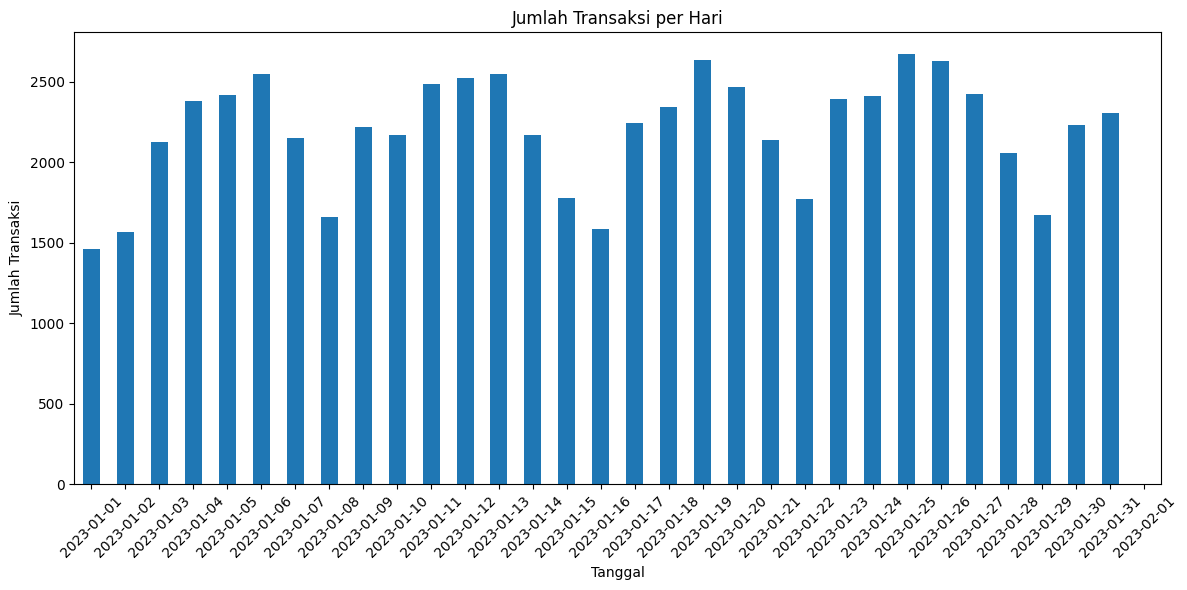


Hasil Cleaning:
----------------
Total data awal: 68211
Total data setelah cleaning: 68207

Distribusi data per bulan setelah cleaning:
lpep_pickup_datetime      1
lpep_pickup_datetime       
2023                  68207

Statistik transaksi per hari setelah cleaning:
count      31.000000
mean     2200.225806
std       348.384434
min      1463.000000
25%      2091.000000
50%      2246.000000
75%      2447.500000
max      2674.000000
Name: VendorID, dtype: float64


In [245]:
def clean_data(df):
    """
    Membersihkan data dari outlier dan anomali
    """
    print("Jumlah data awal:", len(df))
    
    # 1. Filter tahun yang valid (2023)
    valid_years = [2023]
    df_cleaned = df[df['lpep_pickup_datetime'].dt.year.isin(valid_years)]
    print(f"Jumlah data yang dihapus karena tahun tidak valid: {len(df) - len(df_cleaned)}")
    
    # 2. Analisis transaksi per hari sebelum filtering
    daily_trips = df_cleaned.groupby(df_cleaned['lpep_pickup_datetime'].dt.date)['VendorID'].count()
    print("\nStatistik transaksi per hari sebelum filtering:")
    print(daily_trips.describe())
    
    # Visualisasi distribusi transaksi harian
    plt.figure(figsize=(12, 6))
    daily_trips.plot(kind='bar')
    plt.title('Jumlah Transaksi per Hari')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Transaksi')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Filter berdasarkan minimum transaksi per hari (misalnya minimal 100 transaksi)
    min_daily_trips = 100  # bisa disesuaikan
    valid_dates = daily_trips[daily_trips >= min_daily_trips].index
    df_cleaned = df_cleaned[df_cleaned['lpep_pickup_datetime'].dt.date.isin(valid_dates)]
    
    # 4. Hapus data bulan Desember 2022
    df_cleaned = df_cleaned[~((df_cleaned['lpep_pickup_datetime'].dt.year == 2022) & 
                            (df_cleaned['lpep_pickup_datetime'].dt.month == 12))]
    
    # Summary hasil cleaning
    print("\nHasil Cleaning:")
    print("----------------")
    print(f"Total data awal: {len(df)}")
    print(f"Total data setelah cleaning: {len(df_cleaned)}")
    
    # Tampilkan distribusi data per bulan setelah cleaning
    monthly_distribution = df_cleaned.groupby([
        df_cleaned['lpep_pickup_datetime'].dt.year,
        df_cleaned['lpep_pickup_datetime'].dt.month
    ])['VendorID'].count().unstack(fill_value=0)
    
    print("\nDistribusi data per bulan setelah cleaning:")
    print(monthly_distribution)
    
    # Tampilkan statistik transaksi per hari setelah cleaning
    daily_trips_after = df_cleaned.groupby(df_cleaned['lpep_pickup_datetime'].dt.date)['VendorID'].count()
    print("\nStatistik transaksi per hari setelah cleaning:")
    print(daily_trips_after.describe())
    
    return df_cleaned

# Aplikasikan cleaning
df = clean_data(df)

In [246]:
# 7. Feature Engineering
print("\n7. Feature Engineering")
print("--------------------")

def create_features(df):
    # Durasi trip dalam menit
    df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Waktu features
    df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
    df['pickup_day'] = df['lpep_pickup_datetime'].dt.day_name()
    df['pickup_month'] = df['lpep_pickup_datetime'].dt.month
    
    # Speed (mph)
    df['avg_speed'] = np.where(df['trip_duration'] > 0, 
                              df['trip_distance'] / (df['trip_duration'] / 60),
                              0)
    
    return df

df = create_features(df)
df


7. Feature Engineering
--------------------


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration,pickup_hour,pickup_day,pickup_month,avg_speed
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.90,...,1.0,24.18,1.0,1.0,2.75,11.016667,0,Sunday,1,14.051437
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.70,...,1.0,15.84,1.0,1.0,0.00,6.766667,0,Sunday,1,16.049261
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.20,...,1.0,11.64,1.0,1.0,0.00,6.333333,0,Sunday,1,0.000000
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.50,...,1.0,10.20,1.0,1.0,0.00,5.816667,0,Sunday,1,13.409742
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.00,...,1.0,8.00,1.0,1.0,0.00,5.966667,0,Sunday,1,11.061453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,NaN,NaN,49,62,NaN,4070.82,15.70,...,1.0,16.70,NaN,NaN,NaN,13.000000,22,Tuesday,1,18788.400000
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,NaN,NaN,10,205,NaN,2.14,4.41,...,1.0,5.41,NaN,NaN,NaN,8.000000,22,Tuesday,1,16.050000
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,NaN,NaN,66,37,NaN,3.44,16.53,...,1.0,21.04,NaN,NaN,NaN,16.000000,23,Tuesday,1,12.900000
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,NaN,NaN,225,189,NaN,3.03,14.98,...,1.0,19.18,NaN,NaN,NaN,18.000000,23,Tuesday,1,10.100000


- Features tambahan membantu identifikasi pattern error
- Speed dan duration membantu validasi data
- Temporal features untuk analisis trend error

# Rekomendasi Penanganan Data

In [247]:
# 8. Rekomendasi Penanganan Data
def generate_recommendations(df, validation_results, missing_analysis, outlier_analysis):
    # Buat DataFrame untuk rekomendasi missing values
    missing_recs = []
    for col, row in missing_analysis.iterrows():
        if row['Percentage'] == 100:
            rec = 'Kolom tidak digunakan dalam sistem. Dapat diabaikan untuk analisis.'
        elif row['Percentage'] > 0:
            rec = 'Jangan di-drop karena berpotensi system error. Buat flag untuk analisis dan monitor pattern berdasarkan waktu dan lokasi.'
        else:
            continue
        missing_recs.append({
            'Column': col,
            'Missing (%)': row['Percentage'],
            'Recommendation': rec
        })
    missing_recs = pd.DataFrame(missing_recs).set_index('Column')

    # Buat DataFrame untuk rekomendasi data validation
    validation_recs = []
    for issue, count in validation_results.items():
        if count == 0:
            continue
        elif 'DateTime' in issue:
            rec = 'Validasi format datetime dan investigasi penyebab invalid data.'
        elif 'Negative' in issue:
            rec = 'Analisis apakah terkait pembatalan/refund atau system error. Monitor trend dan pattern.'
        elif 'Zero' in issue and 'Distance' not in issue:
            rec = 'Investigasi missing payment atau system error. Track berdasarkan waktu dan vendor.'
        elif 'Distance' in issue:
            rec = 'Validasi data jarak. Periksa apakah terkait pembatalan atau error meteran.'
        elif 'Passenger' in issue:
            rec = 'Validasi input penumpang. Monitor pattern input driver.'
        else:
            rec = 'Flag sebagai potential error. Analisis pattern dan penyebab.'
        validation_recs.append({
            'Issue': issue,
            'Count': count,
            'Recommendation': rec
        })
    validation_recs = pd.DataFrame(validation_recs).set_index('Issue')

    # Buat DataFrame untuk rekomendasi outliers
    outlier_recs = []
    for col, row in outlier_analysis.iterrows():
        if row['Percentage'] == 0:
            continue
        elif 'amount' in col.lower():
            rec = 'Analisis apakah outlier terkait special case (holiday/event) atau potential fraud/error.'
        elif 'distance' in col.lower():
            rec = 'Validasi jarak outlier dengan peta. Periksa potensi error GPS atau meteran.'
        elif 'passenger' in col.lower():
            rec = 'Validasi kesesuaian jumlah penumpang dengan tipe kendaraan.'
        else:
            rec = 'Analisis pattern outlier dan hubungannya dengan system error.'
        outlier_recs.append({
            'Column': col,
            'Outliers (%)': row['Percentage'],
            'Recommendation': rec
        })
    outlier_recs = pd.DataFrame(outlier_recs).set_index('Column')

    # Display rekomendasi dalam format yang lebih ringkas
    print("\nREKOMENDASI PENANGANAN DATA")
    print("===========================")
    
    if len(validation_recs) > 0:
        print("\n1. DATA VALIDATION ISSUES")
        print("------------------------")
        display(validation_recs)
    
    if len(missing_recs) > 0:
        print("\n2. MISSING VALUES")
        print("-----------------")
        # Set display options untuk menampilkan seluruh text
        pd.set_option('display.max_colwidth', None)
        display(missing_recs)
    
    if len(outlier_recs) > 0:
        print("\n3. OUTLIERS")
        print("-----------")
        display(outlier_recs)
    
    print("\nREKOMENDASI UMUM:")
    print("1. Buat sistem scoring untuk reliability data")
    print("2. Analisis korelasi antar error")
    print("3. Track error patterns berdasarkan waktu dan lokasi")
    print("4. Monitor performa per vendor")
    print("5. Investigasi pattern system error")

    return missing_recs, validation_recs, outlier_recs

# Run rekomendasi
missing_recommendations, validation_recommendations, outlier_recommendations = generate_recommendations(
    df, validation_results, missing_analysis, outlier_analysis
)


REKOMENDASI PENANGANAN DATA

1. DATA VALIDATION ISSUES
------------------------


,Count,Recommendation
Issue,,
Negative Total Amount,179,Analisis apakah terkait pembatalan/refund atau system error. Monitor trend dan pattern.
Zero Improvement Surcharge,186,Investigasi missing payment atau system error. Track berdasarkan waktu dan vendor.
Zero MTA Tax,5778,Investigasi missing payment atau system error. Track berdasarkan waktu dan vendor.
Zero or Negative Distance,3350,Analisis apakah terkait pembatalan/refund atau system error. Monitor trend dan pattern.
Invalid Passenger Count,336,Validasi input penumpang. Monitor pattern input driver.



2. MISSING VALUES
-----------------


,Missing (%),Recommendation
Column,,
ehail_fee,100.00,Kolom tidak digunakan dalam sistem. Dapat diabaikan untuk analisis.
trip_type,6.35,Jangan di-drop karena berpotensi system error. Buat flag untuk analisis dan monitor pattern berdasarkan waktu dan lokasi.
store_and_fwd_flag,6.34,Jangan di-drop karena berpotensi system error. Buat flag untuk analisis dan monitor pattern berdasarkan waktu dan lokasi.
passenger_count,6.34,Jangan di-drop karena berpotensi system error. Buat flag untuk analisis dan monitor pattern berdasarkan waktu dan lokasi.
RatecodeID,6.34,Jangan di-drop karena berpotensi system error. Buat flag untuk analisis dan monitor pattern berdasarkan waktu dan lokasi.
payment_type,6.34,Jangan di-drop karena berpotensi system error. Buat flag untuk analisis dan monitor pattern berdasarkan waktu dan lokasi.
congestion_surcharge,6.34,Jangan di-drop karena berpotensi system error. Buat flag untuk analisis dan monitor pattern berdasarkan waktu dan lokasi.



3. OUTLIERS
-----------


,Outliers (%),Recommendation
Column,,
VendorID,13.697204,Analisis pattern outlier dan hubungannya dengan system error.
RatecodeID,2.615414,Analisis pattern outlier dan hubungannya dengan system error.
PULocationID,8.991218,Analisis pattern outlier dan hubungannya dengan system error.
passenger_count,14.056384,Validasi kesesuaian jumlah penumpang dengan tipe kendaraan.
trip_distance,8.464910,Validasi jarak outlier dengan peta. Periksa potensi error GPS atau meteran.
fare_amount,6.361144,Analisis apakah outlier terkait special case (holiday/event) atau potential fraud/error.
extra,5.257217,Analisis pattern outlier dan hubungannya dengan system error.
mta_tax,22.040433,Analisis pattern outlier dan hubungannya dengan system error.
tip_amount,2.998050,Analisis apakah outlier terkait special case (holiday/event) atau potential fraud/error.



REKOMENDASI UMUM:
1. Buat sistem scoring untuk reliability data
2. Analisis korelasi antar error
3. Track error patterns berdasarkan waktu dan lokasi
4. Monitor performa per vendor
5. Investigasi pattern system error


In [248]:
def enhance_dataframe(df):
    """
    Menambahkan kolom-kolom yang berguna untuk analisis dan membersihkan kolom yang tidak diperlukan
    """
    print("Menambahkan kolom-kolom baru dan membersihkan dataset...")
    
    # 1. Drop kolom yang tidak diperlukan
    columns_to_drop = ['ehail_fee']  # Karena semua nilainya null
    df = df.drop(columns=columns_to_drop)
    
    # 2. Konversi datetime
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    
    # 3. Tambahkan kolom-kolom baru
    
    # Time-related features
    df['trip_duration_minutes'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
    df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
    df['pickup_day'] = df['lpep_pickup_datetime'].dt.day_name()
    df['pickup_date'] = df['lpep_pickup_datetime'].dt.date
    df['pickup_month'] = df['lpep_pickup_datetime'].dt.month
    df['is_weekend'] = df['lpep_pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Peak hours (7-10 AM dan 4-7 PM pada weekdays)
    df['is_peak_hours'] = (
        (~df['is_weekend'].astype(bool)) & 
        (((df['pickup_hour'] >= 7) & (df['pickup_hour'] <= 10)) |
         ((df['pickup_hour'] >= 16) & (df['pickup_hour'] <= 19)))
    ).astype(int)
    
    # Trip metrics
    df['avg_speed_mph'] = np.where(
        df['trip_duration_minutes'] > 0,
        df['trip_distance'] / (df['trip_duration_minutes'] / 60),
        0
    )
    
    # Revenue metrics
    df['fare_per_mile'] = np.where(
        df['trip_distance'] > 0,
        df['fare_amount'] / df['trip_distance'],
        0
    )
    
    df['fare_per_minute'] = np.where(
        df['trip_duration_minutes'] > 0,
        df['fare_amount'] / df['trip_duration_minutes'],
        0
    )
    
    # Surcharges total
    df['total_surcharges'] = df['improvement_surcharge'] + df['mta_tax'] + df['congestion_surcharge'].fillna(0)
    
    # Payment breakdown
    df['non_fare_charges'] = df['total_amount'] - df['fare_amount']
    df['is_credit_card'] = (df['payment_type'] == 1).astype(int)
    
    # Location features
    df['is_same_zone'] = (df['PULocationID'] == df['DOLocationID']).astype(int)
    
    print("\nKolom yang dihapus:")
    print(columns_to_drop)
    
    print("\nKolom baru yang ditambahkan:")
    new_columns = [
        'trip_duration_minutes',
        'pickup_hour',
        'pickup_day',
        'pickup_date',
        'pickup_month',
        'is_weekend',
        'is_peak_hours',
        'avg_speed_mph',
        'fare_per_mile',
        'fare_per_minute',
        'total_surcharges',
        'non_fare_charges',
        'is_credit_card',
        'is_same_zone'
    ]
    for col in new_columns:
        print(f"- {col}")

    # Basic statistics untuk kolom baru
    print("\nStatistik dasar untuk kolom-kolom baru numerik:")
    numeric_new_cols = df[new_columns].select_dtypes(include=['float64', 'int64']).columns
    
    # Membuat DataFrame statistik yang lebih rapi
    stats_df = df[numeric_new_cols].describe().T
    
    # Memformat angka agar lebih mudah dibaca
    formatted_stats = pd.DataFrame({
        'count': stats_df['count'].astype(int),
        'mean': stats_df['mean'].round(2),
        'std': stats_df['std'].round(2),
        'min': stats_df['min'].round(2),
        '25%': stats_df['25%'].round(2),
        '50%': stats_df['50%'].round(2),
        '75%': stats_df['75%'].round(2),
        'max': stats_df['max'].round(2)
    })
    
    # Menambahkan deskripsi untuk setiap metrik
    metric_descriptions = {
        'trip_duration_minutes': 'Durasi perjalanan dalam menit',
        'pickup_hour': 'Jam pengambilan (0-23)',
        'pickup_month': 'Bulan pengambilan (1-12)',
        'is_weekend': 'Flag untuk weekend (1) atau weekday (0)',
        'is_peak_hours': 'Flag untuk jam sibuk (1) atau tidak (0)',
        'avg_speed_mph': 'Kecepatan rata-rata dalam mil per jam',
        'fare_per_mile': 'Tarif per mil',
        'fare_per_minute': 'Tarif per menit',
        'total_surcharges': 'Total semua surcharge',
        'non_fare_charges': 'Total biaya di luar fare amount',
        'is_credit_card': 'Flag untuk pembayaran kartu kredit (1) atau tidak (0)',
        'is_same_zone': 'Flag untuk trip dalam zona yang sama (1) atau berbeda (0)'
    }
    
    # Menambahkan kolom deskripsi
    formatted_stats['description'] = formatted_stats.index.map(metric_descriptions)
    
    # Reorder columns untuk menempatkan deskripsi di awal
    cols = ['description'] + [col for col in formatted_stats.columns if col != 'description']
    formatted_stats = formatted_stats[cols]
    
    print("\nStatistik detail untuk kolom-kolom baru:")
    display(formatted_stats)
    
    return df

# Aplikasikan fungsi
df_enhanced = enhance_dataframe(df)

Menambahkan kolom-kolom baru dan membersihkan dataset...

Kolom yang dihapus:
['ehail_fee']

Kolom baru yang ditambahkan:
- trip_duration_minutes
- pickup_hour
- pickup_day
- pickup_date
- pickup_month
- is_weekend
- is_peak_hours
- avg_speed_mph
- fare_per_mile
- fare_per_minute
- total_surcharges
- non_fare_charges
- is_credit_card
- is_same_zone

Statistik dasar untuk kolom-kolom baru numerik:

Statistik detail untuk kolom-kolom baru:


,description,count,mean,std,min,25%,50%,75%,max
trip_duration_minutes,Durasi perjalanan dalam menit,68207,18.08,74.85,0.00,7.22,11.40,17.48,1439.88
is_weekend,Flag untuk weekend (1) atau weekday (0),68207,0.25,0.43,0.00,0.00,0.00,0.00,1.00
is_peak_hours,Flag untuk jam sibuk (1) atau tidak (0),68207,0.39,0.49,0.00,0.00,0.00,1.00,1.00
avg_speed_mph,Kecepatan rata-rata dalam mil per jam,68207,41.55,3605.61,0.00,8.17,10.40,13.49,867842.40
fare_per_mile,Tarif per mil,68207,10.44,138.95,-500.00,5.31,6.50,7.86,19950.00
fare_per_minute,Tarif per menit,68207,5.62,74.91,-750.00,1.04,1.19,1.41,5900.00
total_surcharges,Total semua surcharge,68207,2.22,1.30,-4.25,1.50,1.50,2.50,5.25
non_fare_charges,Total biaya di luar fare amount,68207,5.19,4.17,-12.00,2.44,4.20,7.10,226.22
is_credit_card,Flag untuk pembayaran kartu kredit (1) atau tidak (0),68207,0.60,0.49,0.00,0.00,1.00,1.00,1.00
is_same_zone,Flag untuk trip dalam zona yang sama (1) atau berbeda (0),68207,0.13,0.33,0.00,0.00,0.00,0.00,1.00


In [249]:
def add_zone_categories(df):
    """
    Menambahkan kategorisasi zona berdasarkan lokasi di NYC
    Sumber: https://www.nyc.gov/assets/tlc/downloads/pdf/taxi_zone_map.pdf
    """
    # Manhattan zones (Below 96th Street) - Congestion Surcharge Zone
    manhattan_below_96 = [
        4, 12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 74, 75, 79, 87, 88, 90, 100, 
        103, 104, 105, 107, 113, 114, 116, 120, 125, 127, 128, 137, 140, 141, 
        142, 143, 144, 148, 151, 158, 161, 162, 163, 164, 166, 170, 186, 209, 
        211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 
        246, 249, 261, 262, 263
    ]

    # Manhattan zones (Above 96th Street)
    manhattan_above_96 = [
        120, 127, 128, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 
        162, 163, 164, 165, 166, 167, 168, 169, 170
    ]

    # Airports
    airports = {
        'JFK': 132,  # JFK Airport
        'LGA': 138,  # LaGuardia Airport
        'EWR': 1     # Newark Airport
    }

    # Borough categories
    manhattan_zones = manhattan_below_96 + manhattan_above_96
    brooklyn_zones = list(range(80, 125))  # Approximate range
    queens_zones = list(range(126, 187))   # Approximate range
    bronx_zones = list(range(3, 29))       # Approximate range
    staten_island_zones = list(range(188, 200))  # Approximate range

    # Add zone categories
    df['pickup_borough'] = pd.cut(
        df['PULocationID'],
        bins=[0, 29, 125, 187, 200, float('inf')],
        labels=['Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Other']
    )
    
    df['dropoff_borough'] = pd.cut(
        df['DOLocationID'],
        bins=[0, 29, 125, 187, 200, float('inf')],
        labels=['Bronx', 'Brooklyn', 'Queens', 'Staten Island', 'Other']
    )

    # Add specific flags
    df['is_manhattan_pickup'] = df['PULocationID'].isin(manhattan_zones).astype(int)
    df['is_manhattan_dropoff'] = df['DOLocationID'].isin(manhattan_zones).astype(int)
    
    df['is_congestion_zone_pickup'] = df['PULocationID'].isin(manhattan_below_96).astype(int)
    df['is_congestion_zone_dropoff'] = df['DOLocationID'].isin(manhattan_below_96).astype(int)
    
    df['is_airport_pickup'] = df['PULocationID'].isin(airports.values()).astype(int)
    df['is_airport_dropoff'] = df['DOLocationID'].isin(airports.values()).astype(int)

    # Add specific airport flags
    for airport, zone_id in airports.items():
        df[f'is_{airport.lower()}_pickup'] = (df['PULocationID'] == zone_id).astype(int)
        df[f'is_{airport.lower()}_dropoff'] = (df['DOLocationID'] == zone_id).astype(int)

    return df

def add_time_features(df):
    """
    Menambahkan fitur-fitur terkait waktu
    """
    # Konversi datetime
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    
    # Time-related features
    df['trip_duration_minutes'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60
    df['pickup_hour'] = df['lpep_pickup_datetime'].dt.hour
    df['pickup_day'] = df['lpep_pickup_datetime'].dt.day_name()
    df['pickup_date'] = df['lpep_pickup_datetime'].dt.date
    df['pickup_month'] = df['lpep_pickup_datetime'].dt.month
    df['is_weekend'] = df['lpep_pickup_datetime'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Peak hours (7-10 AM dan 4-7 PM pada weekdays)
    df['is_peak_hours'] = (
        (~df['is_weekend'].astype(bool)) & 
        (((df['pickup_hour'] >= 7) & (df['pickup_hour'] <= 10)) |
         ((df['pickup_hour'] >= 16) & (df['pickup_hour'] <= 19)))
    ).astype(int)
    
    return df

def add_trip_metrics(df):
    """
    Menambahkan metrik-metrik perjalanan
    """
    # Trip metrics
    df['avg_speed_mph'] = np.where(
        df['trip_duration_minutes'] > 0,
        df['trip_distance'] / (df['trip_duration_minutes'] / 60),
        0
    )
    
    # Revenue metrics
    df['fare_per_mile'] = np.where(
        df['trip_distance'] > 0,
        df['fare_amount'] / df['trip_distance'],
        0
    )
    
    df['fare_per_minute'] = np.where(
        df['trip_duration_minutes'] > 0,
        df['fare_amount'] / df['trip_duration_minutes'],
        0
    )
    
    # Surcharges total
    df['total_surcharges'] = df['improvement_surcharge'] + df['mta_tax'] + df['congestion_surcharge'].fillna(0)
    
    # Payment breakdown
    df['non_fare_charges'] = df['total_amount'] - df['fare_amount']
    df['is_credit_card'] = (df['payment_type'] == 1).astype(int)
    
    # Location features
    df['is_same_zone'] = (df['PULocationID'] == df['DOLocationID']).astype(int)
    
    return df

def generate_statistics(df):
    """
    Menghasilkan statistik untuk kolom-kolom baru
    """
    # Mendefinisikan kolom-kolom untuk statistik
    numeric_columns = [
        'trip_duration_minutes', 'avg_speed_mph', 'fare_per_mile', 'fare_per_minute',
        'total_surcharges', 'non_fare_charges'
    ]
    
    # Membuat DataFrame statistik
    stats_df = df[numeric_columns].describe().T
    
    # Memformat angka
    formatted_stats = pd.DataFrame({
        'count': stats_df['count'].astype(int),
        'mean': stats_df['mean'].round(2),
        'std': stats_df['std'].round(2),
        'min': stats_df['min'].round(2),
        '25%': stats_df['25%'].round(2),
        '50%': stats_df['50%'].round(2),
        '75%': stats_df['75%'].round(2),
        'max': stats_df['max'].round(2)
    })
    
    # Menambahkan deskripsi
    metric_descriptions = {
        'trip_duration_minutes': 'Durasi perjalanan dalam menit',
        'avg_speed_mph': 'Kecepatan rata-rata dalam mil per jam',
        'fare_per_mile': 'Tarif per mil',
        'fare_per_minute': 'Tarif per menit',
        'total_surcharges': 'Total semua surcharge',
        'non_fare_charges': 'Total biaya di luar fare amount'
    }
    
    formatted_stats['description'] = formatted_stats.index.map(metric_descriptions)
    cols = ['description'] + [col for col in formatted_stats.columns if col != 'description']
    formatted_stats = formatted_stats[cols]
    
    return formatted_stats

def generate_zone_statistics(df):
    """
    Menghasilkan statistik untuk zona
    """
    # Borough statistics
    borough_stats = pd.DataFrame({
        'Pickup Count': df['pickup_borough'].value_counts(),
        'Pickup %': df['pickup_borough'].value_counts(normalize=True) * 100,
        'Dropoff Count': df['dropoff_borough'].value_counts(),
        'Dropoff %': df['dropoff_borough'].value_counts(normalize=True) * 100
    }).round(2)
    
    # Special zone statistics
    special_zones_stats = pd.DataFrame({
        'Zone Type': [
            'Manhattan (Total)',
            'Manhattan (Below 96th)',
            'Airports (Total)',
            'JFK Airport',
            'LaGuardia Airport',
            'Newark Airport'
        ],
        'Pickup Trips': [
            df['is_manhattan_pickup'].sum(),
            df['is_congestion_zone_pickup'].sum(),
            df['is_airport_pickup'].sum(),
            df['is_jfk_pickup'].sum(),
            df['is_lga_pickup'].sum(),
            df['is_ewr_pickup'].sum()
        ],
        'Pickup %': [
            df['is_manhattan_pickup'].mean() * 100,
            df['is_congestion_zone_pickup'].mean() * 100,
            df['is_airport_pickup'].mean() * 100,
            df['is_jfk_pickup'].mean() * 100,
            df['is_lga_pickup'].mean() * 100,
            df['is_ewr_pickup'].mean() * 100
        ],
        'Dropoff Trips': [
            df['is_manhattan_dropoff'].sum(),
            df['is_congestion_zone_dropoff'].sum(),
            df['is_airport_dropoff'].sum(),
            df['is_jfk_dropoff'].sum(),
            df['is_lga_dropoff'].sum(),
            df['is_ewr_dropoff'].sum()
        ],
        'Dropoff %': [
            df['is_manhattan_dropoff'].mean() * 100,
            df['is_congestion_zone_dropoff'].mean() * 100,
            df['is_airport_dropoff'].mean() * 100,
            df['is_jfk_dropoff'].mean() * 100,
            df['is_lga_dropoff'].mean() * 100,
            df['is_ewr_dropoff'].mean() * 100
        ]
    }).round(2)
    
    return borough_stats, special_zones_stats

# Add features
df = add_zone_categories(df)
df = add_time_features(df)
df = add_trip_metrics(df)

# Generate statistics
print("\nSTATISTIK METRIK PERJALANAN")
print("===========================")
trip_stats = generate_statistics(df)
display(trip_stats)

print("\nSTATISTIK ZONA")
print("==============")
borough_stats, special_zones_stats = generate_zone_statistics(df)
print("\nBorough Statistics:")
display(borough_stats)
print("\nSpecial Zone Statistics:")
display(special_zones_stats)

print("\nSumber Data:")
print("1. NYC TLC Taxi Zone Map: https://www.nyc.gov/assets/tlc/downloads/pdf/taxi_zone_map.pdf")
print("2. Congestion Surcharge Zone: https://www.nyc.gov/site/tlc/about/congestion-surcharge.page")
print("3. Airport Access Rules: https://www.nyc.gov/site/tlc/businesses/airport-access.page")


STATISTIK METRIK PERJALANAN


,description,count,mean,std,min,25%,50%,75%,max
trip_duration_minutes,Durasi perjalanan dalam menit,68207,18.08,74.85,0.00,7.22,11.40,17.48,1439.88
avg_speed_mph,Kecepatan rata-rata dalam mil per jam,68207,41.55,3605.61,0.00,8.17,10.40,13.49,867842.40
fare_per_mile,Tarif per mil,68207,10.44,138.95,-500.00,5.31,6.50,7.86,19950.00
fare_per_minute,Tarif per menit,68207,5.62,74.91,-750.00,1.04,1.19,1.41,5900.00
total_surcharges,Total semua surcharge,68207,2.22,1.30,-4.25,1.50,1.50,2.50,5.25
non_fare_charges,Total biaya di luar fare amount,68207,5.19,4.17,-12.00,2.44,4.20,7.10,226.22



STATISTIK ZONA

Borough Statistics:


,Pickup Count,Pickup %,Dropoff Count,Dropoff %
Bronx,3402,4.99,3694,5.42
Brooklyn,47268,69.30,25853,37.90
Queens,9738,14.28,17967,26.34
Staten Island,1285,1.88,2239,3.28
Other,6514,9.55,18454,27.06



Special Zone Statistics:


,Zone Type,Pickup Trips,Pickup %,Dropoff Trips,Dropoff %
0,Manhattan (Total),39827,58.39,40870,59.92
1,Manhattan (Below 96th),38935,57.08,38810,56.90
2,Airports (Total),39,0.06,1865,2.73
3,JFK Airport,15,0.02,519,0.76
4,LaGuardia Airport,23,0.03,1321,1.94
5,Newark Airport,1,0.00,25,0.04



Sumber Data:
1. NYC TLC Taxi Zone Map: https://www.nyc.gov/assets/tlc/downloads/pdf/taxi_zone_map.pdf
2. Congestion Surcharge Zone: https://www.nyc.gov/site/tlc/about/congestion-surcharge.page
3. Airport Access Rules: https://www.nyc.gov/site/tlc/businesses/airport-access.page


### Dokumentasi Fitur Tambahan

In [250]:
def create_feature_documentation(df):
    """
    Membuat dokumentasi lengkap untuk semua kolom tambahan
    """
    # Definisi feature descriptions
    feature_desc = {
        # Time Features
        'trip_duration_minutes': 'Durasi perjalanan dalam menit, dihitung dari selisih waktu dropoff dan pickup',
        'pickup_hour': 'Jam saat pickup (0-23)',
        'pickup_day': 'Hari saat pickup',
        'pickup_date': 'Tanggal pickup',
        'pickup_month': 'Bulan pickup (1-12)',
        'is_weekend': 'Flag untuk weekend (1) atau weekday (0)',
        'is_peak_hours': 'Flag untuk jam sibuk (1: 7-10AM atau 4-7PM pada weekday) atau tidak (0)',
        
        # Zone Features
        'pickup_borough': 'Borough tempat pickup (Bronx, Brooklyn, Queens, Staten Island, Other)',
        'dropoff_borough': 'Borough tempat dropoff',
        'is_manhattan_pickup': 'Flag untuk pickup di Manhattan (1) atau tidak (0)',
        'is_manhattan_dropoff': 'Flag untuk dropoff di Manhattan (1) atau tidak (0)',
        'is_congestion_zone_pickup': 'Flag untuk pickup di Manhattan below 96th Street (1) atau tidak (0)',
        'is_congestion_zone_dropoff': 'Flag untuk dropoff di Manhattan below 96th Street (1) atau tidak (0)',
        'is_airport_pickup': 'Flag untuk pickup di airport (1) atau tidak (0)',
        'is_airport_dropoff': 'Flag untuk dropoff di airport (1) atau tidak (0)',
        'is_jfk_pickup': 'Flag untuk pickup di JFK Airport (1) atau tidak (0)',
        'is_jfk_dropoff': 'Flag untuk dropoff di JFK Airport (1) atau tidak (0)',
        'is_lga_pickup': 'Flag untuk pickup di LaGuardia Airport (1) atau tidak (0)',
        'is_lga_dropoff': 'Flag untuk dropoff di LaGuardia Airport (1) atau tidak (0)',
        'is_ewr_pickup': 'Flag untuk pickup di Newark Airport (1) atau tidak (0)',
        'is_ewr_dropoff': 'Flag untuk dropoff di Newark Airport (1) atau tidak (0)',
        'is_same_zone': 'Flag untuk pickup dan dropoff di zona yang sama (1) atau berbeda (0)',
        
        # Trip Metrics
        'avg_speed_mph': 'Kecepatan rata-rata dalam mil per jam',
        'fare_per_mile': 'Tarif per mil perjalanan',
        'fare_per_minute': 'Tarif per menit perjalanan',
        
        # Payment Features
        'total_surcharges': 'Total surcharge (improvement + MTA tax + congestion)',
        'non_fare_charges': 'Total biaya diluar fare amount',
        'is_credit_card': 'Flag untuk pembayaran dengan kartu kredit (1) atau tidak (0)'
    }
    
    # Membuat dataframe untuk dokumentasi
    doc_rows = []
    
    for feature, description in feature_desc.items():
        row = {'Feature': feature, 'Description': description}
        
        if feature in df.columns:  # Check if feature exists in dataframe
            if df[feature].dtype in ['int64', 'float64']:
                # Numeric features
                row.update({
                    'Data Type': str(df[feature].dtype),
                    'Mean': f"{df[feature].mean():.2f}",
                    'Std': f"{df[feature].std():.2f}",
                    'Min': f"{df[feature].min():.2f}",
                    'Max': f"{df[feature].max():.2f}",
                    'Null Values': df[feature].isnull().sum(),
                    'Null %': f"{(df[feature].isnull().sum() / len(df) * 100):.2f}%"
                })
                
                # Additional stats for flag features (0/1)
                if set(df[feature].unique()) <= {0, 1}:
                    row['True Count (1)'] = df[feature].sum()
                    row['True %'] = f"{(df[feature].mean() * 100):.2f}%"
                
            else:
                # Categorical features
                row.update({
                    'Data Type': str(df[feature].dtype),
                    'Unique Values': df[feature].nunique(),
                    'Most Common': df[feature].mode()[0],
                    'Most Common %': f"{(df[feature].value_counts().iloc[0] / len(df) * 100):.2f}%",
                    'Null Values': df[feature].isnull().sum(),
                    'Null %': f"{(df[feature].isnull().sum() / len(df) * 100):.2f}%"
                })
        
        doc_rows.append(row)
    
    # Create documentation dataframe
    doc_df = pd.DataFrame(doc_rows)
    
    # Reorder columns based on data type
    numeric_cols = ['Data Type', 'Mean', 'Std', 'Min', 'Max', 'True Count (1)', 'True %', 
                   'Unique Values', 'Most Common', 'Most Common %', 'Null Values', 'Null %']
    available_cols = ['Feature', 'Description'] + [col for col in numeric_cols if col in doc_df.columns]
    doc_df = doc_df[available_cols]
    
    # Group features by category
    print("DOKUMENTASI FITUR TAMBAHAN")
    print("==========================")
    
    categories = {
        'Time Features': [col for col in doc_df['Feature'] if col in 
                         ['trip_duration_minutes', 'pickup_hour', 'pickup_day', 'pickup_date', 
                          'pickup_month', 'is_weekend', 'is_peak_hours']],
        'Zone Features': [col for col in doc_df['Feature'] if 'zone' in col.lower() or 
                         'borough' in col.lower() or 'manhattan' in col.lower() or 
                         'airport' in col.lower()],
        'Trip Metrics': [col for col in doc_df['Feature'] if col in 
                        ['avg_speed_mph', 'fare_per_mile', 'fare_per_minute']],
        'Payment Features': [col for col in doc_df['Feature'] if col in 
                           ['total_surcharges', 'non_fare_charges', 'is_credit_card']]
    }
    
    for category, features in categories.items():
        print(f"\n{category}:")
        print("-" * len(category))
        display(doc_df[doc_df['Feature'].isin(features)])
    
    return doc_df

# Generate documentation
feature_documentation = create_feature_documentation(df)

DOKUMENTASI FITUR TAMBAHAN

Time Features:
-------------


,Feature,Description,Data Type,Mean,Std,Min,Max,True Count (1),True %,Unique Values,Most Common,Most Common %,Null Values,Null %
0,trip_duration_minutes,"Durasi perjalanan dalam menit, dihitung dari selisih waktu dropoff dan pickup",float64,18.08,74.85,0.00,1439.88,NaN,NaN,NaN,NaN,NaN,0,0.00%
1,pickup_hour,Jam saat pickup (0-23),int32,NaN,NaN,NaN,NaN,NaN,NaN,24.0,18,7.68%,0,0.00%
2,pickup_day,Hari saat pickup,object,NaN,NaN,NaN,NaN,NaN,NaN,7.0,Tuesday,16.51%,0,0.00%
3,pickup_date,Tanggal pickup,object,NaN,NaN,NaN,NaN,NaN,NaN,31.0,2023-01-25,3.92%,0,0.00%
4,pickup_month,Bulan pickup (1-12),int32,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,100.00%,0,0.00%
5,is_weekend,Flag untuk weekend (1) atau weekday (0),int64,0.25,0.43,0.00,1.00,16867.0,24.73%,NaN,NaN,NaN,0,0.00%
6,is_peak_hours,Flag untuk jam sibuk (1: 7-10AM atau 4-7PM pada weekday) atau tidak (0),int64,0.39,0.49,0.00,1.00,26527.0,38.89%,NaN,NaN,NaN,0,0.00%



Zone Features:
-------------


,Feature,Description,Data Type,Mean,Std,Min,Max,True Count (1),True %,Unique Values,Most Common,Most Common %,Null Values,Null %
7,pickup_borough,"Borough tempat pickup (Bronx, Brooklyn, Queens, Staten Island, Other)",category,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Brooklyn,69.30%,0,0.00%
8,dropoff_borough,Borough tempat dropoff,category,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Brooklyn,37.90%,0,0.00%
9,is_manhattan_pickup,Flag untuk pickup di Manhattan (1) atau tidak (0),int64,0.58,0.49,0.00,1.00,39827.0,58.39%,NaN,NaN,NaN,0,0.00%
10,is_manhattan_dropoff,Flag untuk dropoff di Manhattan (1) atau tidak (0),int64,0.60,0.49,0.00,1.00,40870.0,59.92%,NaN,NaN,NaN,0,0.00%
11,is_congestion_zone_pickup,Flag untuk pickup di Manhattan below 96th Street (1) atau tidak (0),int64,0.57,0.49,0.00,1.00,38935.0,57.08%,NaN,NaN,NaN,0,0.00%
12,is_congestion_zone_dropoff,Flag untuk dropoff di Manhattan below 96th Street (1) atau tidak (0),int64,0.57,0.50,0.00,1.00,38810.0,56.90%,NaN,NaN,NaN,0,0.00%
13,is_airport_pickup,Flag untuk pickup di airport (1) atau tidak (0),int64,0.00,0.02,0.00,1.00,39.0,0.06%,NaN,NaN,NaN,0,0.00%
14,is_airport_dropoff,Flag untuk dropoff di airport (1) atau tidak (0),int64,0.03,0.16,0.00,1.00,1865.0,2.73%,NaN,NaN,NaN,0,0.00%
21,is_same_zone,Flag untuk pickup dan dropoff di zona yang sama (1) atau berbeda (0),int64,0.13,0.33,0.00,1.00,8628.0,12.65%,NaN,NaN,NaN,0,0.00%



Trip Metrics:
------------


,Feature,Description,Data Type,Mean,Std,Min,Max,True Count (1),True %,Unique Values,Most Common,Most Common %,Null Values,Null %
22,avg_speed_mph,Kecepatan rata-rata dalam mil per jam,float64,41.55,3605.61,0.00,867842.40,NaN,NaN,NaN,NaN,NaN,0,0.00%
23,fare_per_mile,Tarif per mil perjalanan,float64,10.44,138.95,-500.00,19950.00,NaN,NaN,NaN,NaN,NaN,0,0.00%
24,fare_per_minute,Tarif per menit perjalanan,float64,5.62,74.91,-750.00,5900.00,NaN,NaN,NaN,NaN,NaN,0,0.00%



Payment Features:
----------------


,Feature,Description,Data Type,Mean,Std,Min,Max,True Count (1),True %,Unique Values,Most Common,Most Common %,Null Values,Null %
25,total_surcharges,Total surcharge (improvement + MTA tax + congestion),float64,2.22,1.30,-4.25,5.25,NaN,NaN,NaN,NaN,NaN,0,0.00%
26,non_fare_charges,Total biaya diluar fare amount,float64,5.19,4.17,-12.00,226.22,NaN,NaN,NaN,NaN,NaN,0,0.00%
27,is_credit_card,Flag untuk pembayaran dengan kartu kredit (1) atau tidak (0),int64,0.60,0.49,0.00,1.00,40684.0,59.65%,NaN,NaN,NaN,0,0.00%


### Penambahan Flag Error dan kondisi khusus

In [251]:
def add_error_flags(df):
    """
    Menambahkan flag untuk berbagai jenis error dan kategori khusus berdasarkan aturan NYC TLC
    """
    print("Menambahkan flag untuk error dan kategori khusus...")

    # Referensi validasi:
    validation_rules = {
        'System Error': {
            'source': 'NYC TLC Technology System Rules §75-25(h)',
            'url': 'https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_75.pdf',
            'rules': [
                'Store and forward flag mengindikasikan masalah konektivitas',
                'Improvement surcharge wajib ($0.30)',
                'MTA tax wajib ($0.50)',
                'Congestion surcharge wajib untuk Manhattan below 96th ($2.50)'
            ]
        },
        'Trip Duration': {
            'source': 'NYC TLC Driver Rules §80-14(g)',
            'url': 'https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_80.pdf',
            'rules': [
                'Maximum shift duration: 12 hours',
                'Minimum trip duration: positive value'
            ]
        },
        'Trip Distance': {
            'source': 'NYC TLC Taximeter Rules §58-26(d)(2)',
            'url': 'https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf',
            'rules': [
                'Maximum trip distance: 100 miles',
                'Minimum trip distance: positive value'
            ]
        },
        'Vehicle Speed': {
            'source': 'NY State Speed Limits & NYC TLC Best Practices',
            'url': 'https://www.ny.gov/sites/default/files/2021-09/SpeedLimitReport.pdf',
            'rules': [
                'Maximum highway speed: 65 mph',
                'Additional buffer: 15 mph',
                'Maximum reasonable speed: 80 mph'
            ]
        },
        'Passenger Count': {
            'source': 'NYC TLC Vehicle Rules §59A-29',
            'url': 'https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_59.pdf',
            'rules': [
                'Standard taxi capacity: maximum 6 passengers',
                'Minimum passenger count: 1'
            ]
        },
        'Fare Rules': {
            'source': 'NYC TLC Rate Rules §58-26(d)(1)',
            'url': 'https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf',
            'rules': [
                'Minimum fare amount: positive value',
                'Maximum rate per mile: $50',
                'Maximum rate per minute: $5'
            ]
        },
        'RateCode': {
            'source': 'NYC TLC Rate Rules §58-26(d)(1)',
            'url': 'https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf',
            'rules': [
                'Standard rate (1)',
                'JFK (2)',
                'Newark (3)',
                'Nassau or Westchester (4)',
                'Negotiated fare (5)',
                'Group ride (6)'
            ]
        }
    }

    # Clean RateCodeID
    print("\nMembersihkan RateCodeID...")
    invalid_ratecode_count = len(df[df['RatecodeID'] == 99])
    invalid_ratecode_percent = (invalid_ratecode_count / len(df) * 100)
    print(f"Ditemukan {invalid_ratecode_count:,} data dengan RateCodeID = 99 ({invalid_ratecode_percent}%)")
    df.loc[df['RatecodeID'] == 99, 'RatecodeID'] = np.nan

    # 1. System Error Flags
    # Pecah System Error Flags menjadi lebih spesifik
    # a. Store and Forward Error
    df['flag_store_fwd_error'] = (
        (df['store_and_fwd_flag'] == 'Y') |     # Data disimpan offline
        (df['store_and_fwd_flag'].isna())       # Missing flag
    ).astype(int)

    # b. Surcharge Error
    df['flag_improvement_surcharge_error'] = (df['improvement_surcharge'] == 0).astype(int)
    df['flag_mta_tax_error'] = (df['mta_tax'] == 0).astype(int)
    df['flag_congestion_surcharge_error'] = (
        (df['is_congestion_zone_pickup'] == 1) & 
        (df['congestion_surcharge'] == 0)
    ).astype(int)

    # Composite System Error
    df['flag_system_error'] = (
        (df['flag_store_fwd_error'] == 1) |
        (df['flag_improvement_surcharge_error'] == 1) |
        (df['flag_mta_tax_error'] == 1) |
        (df['flag_congestion_surcharge_error'] == 1)
    ).astype(int)

    # 2. Trip Error/Invalid Flags
    df['flag_invalid_duration'] = (
        (df['trip_duration_minutes'] <= 0) |
        (df['trip_duration_minutes'] > 720)  # 12 hours in minutes
    ).astype(int)

    df['flag_invalid_distance'] = (
        (df['trip_distance'] <= 0) |
        (df['trip_distance'] > 100)  # Based on NYC TLC rules
    ).astype(int)

    df['flag_invalid_speed'] = (
        (df['avg_speed_mph'] > 80) |  # NY speed limit + buffer
        ((df['trip_distance'] > 0) & (df['trip_duration_minutes'] <= 0))
    ).astype(int)

    df['flag_invalid_passenger'] = (
        (df['passenger_count'] <= 0) |
        (df['passenger_count'] > 6)  # Standard taxi capacity
    ).astype(int)

    # RateCode Flag
    df['flag_invalid_ratecode'] = (
        df['RatecodeID'].isna() | 
        (~df['RatecodeID'].isin([1, 2, 3, 4, 5, 6]))
    ).astype(int)

    # 3. Payment Error/Invalid Flags
    df['flag_negative_amount'] = (df['total_amount'] < 0).astype(int)
    
    df['flag_zero_fare'] = (
        (df['fare_amount'] == 0) & 
        (df['trip_distance'] > 0) & 
        (df['trip_duration_minutes'] > 0)
    ).astype(int)

    df['flag_high_fare'] = (
        (df['fare_per_mile'] > 50) |  # TLC maximum rate
        (df['fare_per_minute'] > 5)    # TLC maximum rate
    ).astype(int)

    # 4. Cancellation/Voided Trip Flags
    df['flag_cancelled_trip'] = (
        (df['payment_type'] == 6) |  # Voided trip
        ((df['trip_duration_minutes'] < 3) & (df['trip_distance'] < 0.3))  # Very short trips
    ).astype(int)

    # 5. Composite Error Categories
    df['flag_technical_error'] = (
        (df['flag_system_error'] == 1) |
        (df['flag_invalid_duration'] == 1) |
        (df['flag_invalid_distance'] == 1) |
        (df['flag_invalid_speed'] == 1) |
        (df['flag_invalid_ratecode'] == 1)  
    ).astype(int)

    df['flag_payment_error'] = (
        (df['flag_negative_amount'] == 1) |
        (df['flag_zero_fare'] == 1) |
        (df['flag_high_fare'] == 1)
    ).astype(int)

    # 6. Overall Error Flag
    df['flag_any_error'] = (
        (df['flag_technical_error'] == 1) |
        (df['flag_payment_error'] == 1) |
        (df['flag_invalid_passenger'] == 1)
    ).astype(int)

    # Prepare data for error statistics
    error_types = [
        'Store and Forward Error',
        'Improvement Surcharge Error',
        'MTA Tax Error',
        'Congestion Surcharge Error',
        'System Error (Composite)',
        'Invalid RateCode',  
        'Invalid Duration',
        'Invalid Distance',
        'Invalid Speed',
        'Invalid Passenger Count',
        'Negative Amount',
        'Zero Fare',
        'High Fare',
        'Cancelled Trip',
        'Technical Error (Composite)',
        'Payment Error (Composite)',
        'Any Error'
    ]
    
    flag_columns = [
        'flag_store_fwd_error',
        'flag_improvement_surcharge_error',
        'flag_mta_tax_error',
        'flag_congestion_surcharge_error',
        'flag_system_error',
        'flag_invalid_ratecode',  
        'flag_invalid_duration',
        'flag_invalid_distance',
        'flag_invalid_speed',
        'flag_invalid_passenger',
        'flag_negative_amount',
        'flag_zero_fare',
        'flag_high_fare',
        'flag_cancelled_trip',
        'flag_technical_error',
        'flag_payment_error',
        'flag_any_error'
    ]
    
    descriptions = [
        'Data tersimpan offline atau missing flag yang mengindikasikan masalah konektivitas',
        'Missing improvement surcharge yang wajib ($0.30)',
        'Missing MTA tax yang wajib ($0.50)',
        'Missing congestion surcharge pada zona Manhattan below 96th ($2.50)',
        'Gabungan dari semua system error',
        'RateCodeID invalid atau missing',  
        'Durasi perjalanan tidak valid (≤0 atau >12 jam)',
        'Jarak perjalanan tidak valid (≤0 atau >100 mil)',
        'Kecepatan tidak masuk akal (>80 mph)',
        'Jumlah penumpang tidak valid (≤0 atau >6)',
        'Total amount negatif',
        'Fare amount 0 pada trip valid',
        'Tarif per mil/menit terlalu tinggi',
        'Trip dibatalkan atau sangat singkat',
        'Gabungan error teknis',
        'Gabungan error pembayaran',
        'Ada error apapun'
    ]
    
    validation_sources = [
        validation_rules['System Error']['source'],
        validation_rules['System Error']['source'],
        validation_rules['System Error']['source'],
        validation_rules['System Error']['source'],
        validation_rules['System Error']['source'],
        validation_rules['RateCode']['source'],
        validation_rules['Trip Duration']['source'],
        validation_rules['Trip Distance']['source'],
        validation_rules['Vehicle Speed']['source'],
        validation_rules['Passenger Count']['source'],
        validation_rules['Fare Rules']['source'],
        validation_rules['Fare Rules']['source'],
        validation_rules['Fare Rules']['source'],
        'NYC TLC Trip Rules §58-26',
        'Composite dari technical errors',
        'Composite dari payment errors',
        'Composite dari semua errors'
    ]
    
    references = [
        f'<a href="{validation_rules["System Error"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["System Error"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["System Error"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["System Error"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["System Error"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["RateCode"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["Trip Duration"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["Trip Distance"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["Vehicle Speed"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["Passenger Count"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["Fare Rules"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["Fare Rules"]["url"]}" target="_blank">Link to Rule</a>',
        f'<a href="{validation_rules["Fare Rules"]["url"]}" target="_blank">Link to Rule</a>',
        '<a href="https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf" target="_blank">Link to Rule</a>',
        'Multiple sources',
        'Multiple sources',
        'Multiple sources'
    ]

    # Create error statistics DataFrame
    error_stats = pd.DataFrame({
        'Error Type': error_types,
        'Flag Column': flag_columns,
        'Description': descriptions,
        'Validation Source': validation_sources,
        'Reference': references
    })

    # Calculate statistics
    error_stats['Count'] = [df[col].sum() for col in error_stats['Flag Column']]
    error_stats['Percentage'] = [(df[col].sum() / len(df) * 100).round(2) for col in error_stats['Flag Column']]

    print("\nSTATISTIK ERROR")
    print("===============")
    display(HTML(error_stats[['Error Type', 'Description', 'Validation Source', 'Reference', 'Count', 'Percentage']]
                .to_html(escape=False, index=False)))

    # Analyze error patterns by vendor
    vendor_error_stats = pd.DataFrame({
        'Vendor': ['CMT', 'VeriFone'],
        'VendorID': [1, 2]
    })

    for flag in error_stats['Flag Column']:
        for vendor_id in [1, 2]:
            vendor_pct = (df[df['VendorID'] == vendor_id][flag].mean() * 100).round(2)
            vendor_error_stats.loc[vendor_error_stats['VendorID'] == vendor_id, flag] = vendor_pct

    print("\nPERSENTASE ERROR PER VENDOR")
    print("==========================")
    vendor_cols = ['Vendor'] + list(error_stats['Flag Column'])
    display(vendor_error_stats[vendor_cols])

    return df, error_stats, vendor_error_stats, validation_rules

# Apply error flags
df, error_statistics, vendor_statistics, validation_rules = add_error_flags(df)

Menambahkan flag untuk error dan kategori khusus...

Membersihkan RateCodeID...
Ditemukan 10 data dengan RateCodeID = 99 (0.014661251777676779%)

STATISTIK ERROR


Error Type,Description,Validation Source,Reference,Count,Percentage
Store and Forward Error,Data tersimpan offline atau missing flag yang mengindikasikan masalah konektivitas,NYC TLC Technology System Rules §75-25(h),Link to Rule,4632,6.79
Improvement Surcharge Error,Missing improvement surcharge yang wajib ($0.30),NYC TLC Technology System Rules §75-25(h),Link to Rule,186,0.27
MTA Tax Error,Missing MTA tax yang wajib ($0.50),NYC TLC Technology System Rules §75-25(h),Link to Rule,5777,8.47
Congestion Surcharge Error,Missing congestion surcharge pada zona Manhattan below 96th ($2.50),NYC TLC Technology System Rules §75-25(h),Link to Rule,22239,32.61
System Error (Composite),Gabungan dari semua system error,NYC TLC Technology System Rules §75-25(h),Link to Rule,28086,41.18
Invalid RateCode,RateCodeID invalid atau missing,NYC TLC Rate Rules §58-26(d)(1),Link to Rule,4334,6.35
Invalid Duration,Durasi perjalanan tidak valid (≤0 atau >12 jam),NYC TLC Driver Rules §80-14(g),Link to Rule,263,0.39
Invalid Distance,Jarak perjalanan tidak valid (≤0 atau >100 mil),NYC TLC Taximeter Rules §58-26(d)(2),Link to Rule,3387,4.97
Invalid Speed,Kecepatan tidak masuk akal (>80 mph),NY State Speed Limits & NYC TLC Best Practices,Link to Rule,203,0.30
Invalid Passenger Count,Jumlah penumpang tidak valid (≤0 atau >6),NYC TLC Vehicle Rules §59A-29,Link to Rule,344,0.50



PERSENTASE ERROR PER VENDOR


,Vendor,flag_store_fwd_error,flag_improvement_surcharge_error,flag_mta_tax_error,flag_congestion_surcharge_error,flag_system_error,flag_invalid_ratecode,flag_invalid_duration,flag_invalid_distance,flag_invalid_speed,flag_invalid_passenger,flag_negative_amount,flag_zero_fare,flag_high_fare,flag_cancelled_trip,flag_technical_error,flag_payment_error,flag_any_error
0,CMT,4.67,1.24,0.82,35.00,38.71,1.48,0.35,16.47,0.74,3.34,0.0,0.14,2.22,2.94,52.21,2.35,54.56
1,VeriFone,7.13,0.12,9.68,32.23,41.57,7.13,0.39,3.14,0.23,0.05,0.3,0.01,2.38,3.02,43.23,2.69,43.55


### Analisis Vendor

In [252]:
def analyze_vendor_errors(df, error_stats):
    """
    Menganalisis pattern error per vendor dengan perhitungan yang lebih detail
    """
    # 1. Hitung total trips per vendor
    vendor_totals = df['VendorID'].value_counts().to_dict()
    print("\nTotal trips per vendor:")
    for vendor_id, total in vendor_totals.items():
        print(f"Vendor {vendor_id}: {total:,} trips")

    # 2. Buat DataFrame untuk statistik vendor
    vendor_stats = []
    
    for vendor_id in [1, 2]:  # CMT dan VeriFone
        vendor_data = df[df['VendorID'] == vendor_id]
        vendor_name = 'CMT' if vendor_id == 1 else 'VeriFone'
        
        for flag_col in error_stats['Flag Column']:
            error_count = vendor_data[flag_col].sum()
            vendor_total = len(vendor_data)
            error_percentage = (error_count / vendor_total * 100).round(2)
            
            vendor_stats.append({
                'Vendor': vendor_name,
                'VendorID': vendor_id,
                'Error Type': flag_col,
                'Total Trips': vendor_total,
                'Error Count': error_count,
                'Error Percentage': error_percentage,
                'Contribution to Total Error': (error_count / df[flag_col].sum() * 100).round(2)
            })
    
    vendor_stats_df = pd.DataFrame(vendor_stats)

    # 3. Pivot table untuk memudahkan perbandingan
    vendor_comparison = vendor_stats_df.pivot(
        index='Error Type',
        columns='Vendor',
        values=['Error Percentage', 'Error Count', 'Contribution to Total Error']
    ).round(2)

    print("\nDETAIL ANALISIS ERROR PER VENDOR")
    print("================================")
    print("\nA. Error Percentage (% dari total trips vendor)")
    display(vendor_comparison['Error Percentage'])
    
    print("\nB. Error Count (jumlah trip error)")
    display(vendor_comparison['Error Count'])
    
    print("\nC. Contribution to Total Error (% dari total error type)")
    display(vendor_comparison['Contribution to Total Error'])
    
    return vendor_stats_df, vendor_comparison

# Jalankan analisis detail
vendor_stats_df, vendor_comparison = analyze_vendor_errors(df, error_statistics)


Total trips per vendor:
Vendor 2: 58,864 trips
Vendor 1: 9,343 trips

DETAIL ANALISIS ERROR PER VENDOR

A. Error Percentage (% dari total trips vendor)


Vendor,CMT,VeriFone
Error Type,,
flag_any_error,54.56,43.55
flag_cancelled_trip,2.94,3.02
flag_congestion_surcharge_error,35.00,32.23
flag_high_fare,2.22,2.38
flag_improvement_surcharge_error,1.24,0.12
flag_invalid_distance,16.47,3.14
flag_invalid_duration,0.35,0.39
flag_invalid_passenger,3.34,0.05
flag_invalid_ratecode,1.48,7.13



B. Error Count (jumlah trip error)


Vendor,CMT,VeriFone
Error Type,,
flag_any_error,5098.0,25636.0
flag_cancelled_trip,275.0,1777.0
flag_congestion_surcharge_error,3270.0,18969.0
flag_high_fare,207.0,1399.0
flag_improvement_surcharge_error,116.0,70.0
flag_invalid_distance,1539.0,1848.0
flag_invalid_duration,33.0,230.0
flag_invalid_passenger,312.0,32.0
flag_invalid_ratecode,138.0,4196.0



C. Contribution to Total Error (% dari total error type)


Vendor,CMT,VeriFone
Error Type,,
flag_any_error,16.59,83.41
flag_cancelled_trip,13.40,86.60
flag_congestion_surcharge_error,14.70,85.30
flag_high_fare,12.89,87.11
flag_improvement_surcharge_error,62.37,37.63
flag_invalid_distance,45.44,54.56
flag_invalid_duration,12.55,87.45
flag_invalid_passenger,90.70,9.30
flag_invalid_ratecode,3.18,96.82


# Analisis Awal - System Error NYC TLC untuk kedua Vendor

## Overview Data
| Vendor | Total Trips | % dari Total Trip |
|--------|-------------|-------------------|
| VeriFone | 58,868 | 86.31% |
| CMT | 9,343 | 13.69% |
| **Total** | **68,211** | **100%** |

## Analisis Technical Error

### System Error
- **VeriFone**: 41.57% dari tripnya mengalami system error (24,470 trips)
- **CMT**: 38.71% dari tripnya mengalami system error (3,617 trips)
- **Insight**: Kedua vendor memiliki masalah sistem yang serius, dengan tingkat error >35%

### Store & Forward Error
- **VeriFone**: 7.13% trips offline (4,196 trips)
- **CMT**: 4.67% trips offline (436 trips) 
- **Insight**: VeriFone memiliki masalah konektivitas yang lebih tinggi

### Data Validation Error
1. **Invalid Distance**:
  - CMT: 16.47% (1,539 trips)
  - VeriFone: 3.14% (1,848 trips)
  - **Insight**: CMT memiliki masalah serius dengan pencatatan jarak

2. **Invalid Duration**:
  - Relatif rendah di kedua vendor (<0.5%)
  - VeriFone: 0.39% (231 trips)
  - CMT: 0.35% (33 trips)

3. **Invalid Speed**:
  - Rendah di kedua vendor (<1%)
  - CMT: 0.74% (69 trips)
  - VeriFone: 0.23% (134 trips)

### Payment Error
1. **MTA Tax Error**:
  - VeriFone: 9.68% trips missing MTA tax (5,701 trips)
  - CMT: 0.82% trips missing MTA tax (77 trips)
  - **Critical Issue**: VeriFone memiliki masalah serius dengan koleksi MTA tax

2. **Improvement Surcharge Error**:
  - CMT: 1.24% missing surcharge (116 trips)
  - VeriFone: 0.12% missing surcharge (70 trips)

3. **Congestion Surcharge Error**:
  - CMT: 35% trips bermasalah (3,270 trips)
  - VeriFone: 32.22% trips bermasalah (18,969 trips)
  - **Critical Issue**: Kedua vendor memiliki masalah serius dengan congestion surcharge

## Overall Error Rate
- **CMT**: 54.56% dari total trips memiliki setidaknya satu error (5,098 trips)
- **VeriFone**: 43.55% dari total trips memiliki setidaknya satu error (25,638 trips)

## Rekomendasi

### Prioritas Tinggi
1. **Congestion Surcharge System**:
  - Audit sistem penerapan congestion surcharge kedua vendor
  - >30% error rate tidak dapat diterima

2. **MTA Tax Collection VeriFone**:
  - Investigasi mengapa 9.68% trips VeriFone missing MTA tax
  - Potensi kehilangan revenue signifikan

3. **Distance Calculation CMT**:
  - Review sistem pencatatan jarak CMT
  - 16.47% error rate perlu perbaikan segera

### Prioritas Menengah
1. **Konektivitas Sistem**:
  - Evaluasi infrastruktur konektivitas kedua vendor
  - Target pengurangan offline trips ke <1%

2. **RateCode Validation**:
  - VeriFone: 7.13% invalid RateCode
  - Perbaikan sistem validasi RateCode

### Monitoring Berkelanjutan
1. **Payment Validation**:
  - Track error rate pembayaran
  - Monitor negative amount dan zero fare

2. **Data Quality**:
  - Implementasi real-time validation
  - Regular audit untuk data anomaly

## Impact Analysis

### Revenue Loss Risk
1. **MTA Tax**: ~5,778 trips * $0.50 = $2,889 potensi loss
2. **Improvement Surcharge**: ~186 trips * $0.30 = $55.80 potensi loss
3. **Congestion Surcharge**: ~22,239 trips * $2.50 = $55,597.50 potensi loss

### Total Potensi Revenue Loss
- **Minimum**: $58,542.30 (hanya dari surcharge dan tax yang missing)
- Belum termasuk potential loss dari invalid fare calculation

### Rekomendasi Prioritas
1. Fix congestion surcharge system (highest revenue impact)
2. Perbaikan MTA tax collection di VeriFone
3. Audit sistem pencatatan jarak di CMT

# Initial Data Exploration

### Analisis Revenue Loss NYC TLC

#### Latar Belakang
Berdasarkan regulasi NYC TLC, terdapat tiga jenis surcharge yang wajib dikenakan pada setiap perjalanan taksi:

#### 1. Improvement Surcharge
- **Regulasi**: NYC TLC Rules §58-26(a)(10)
- **Nominal**: $0.30 per trip
- **Ketentuan**: Wajib dikenakan pada SETIAP perjalanan taksi
- **Sumber**: [NYC TLC Rules Chapter 58](https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_58.pdf)

#### 2. MTA Tax
- **Regulasi**: NYC Tax Law §1281(a)
- **Nominal**: $0.50 per trip
- **Ketentuan**: Wajib dikenakan pada SETIAP perjalanan taksi di wilayah NYC
- **Sumber**: [NY State MTA Tax Memo](https://www.tax.ny.gov/pdf/memos/mta_mobility/m19-1mta.pdf)

#### 3. Congestion Surcharge
- **Regulasi**: NYC TLC Rules
- **Nominal**: $2.50 per trip
- **Ketentuan**: Wajib dikenakan untuk SETIAP pickup di Manhattan dibawah 96th Street
- **Sumber**: [NYC TLC Congestion Surcharge FAQ](https://www.nyc.gov/assets/tlc/downloads/pdf/congestion_surcharge_faq.pdf)

#### Identifikasi Masalah
Dari analisis awal data, ditemukan beberapa masalah yang berpotensi menyebabkan kehilangan revenue:

1. Missing Charges:
   - Trip dengan improvement surcharge = 0
   - Trip dengan MTA tax = 0
   - Trip dari Manhattan dibawah 96th Street dengan congestion surcharge = 0

2. Incorrect Amount:
   - Nilai surcharge/tax yang tidak sesuai dengan ketentuan
   - Variasi nilai yang tidak dijelaskan dalam regulasi

3. Potential Issues:
   - System Error: LPEP tidak mencatat charge
   - Human Error: Input manual yang salah
   - Compliance Issue: Tidak mengikuti regulasi
   - Technical Issue: Masalah integrasi sistem

#### Impact
1. Direct Revenue Loss:
   - Kehilangan pendapatan dari missing charges
   - Undercharge dari incorrect amount

2. Compliance Risk:
   - Ketidaksesuaian dengan regulasi NYC TLC
   - Potensi penalti atau sanksi

3. Data Quality:
   - Masalah integritas data
   - Kesulitan dalam monitoring dan audit

Berdasarkan temuan ini, berikut adalah analisis detail untuk mengukur besarnya revenue loss dan mengidentifikasi pattern yang menyebabkannya:

=== Revenue Analysis Summary ===


,Metric,Actual Revenue ($),Potential Revenue ($),Revenue Gap ($),Gap Percentage (%)
0,MTA Tax,40129.75,43100.75,2971.00,6.89
1,Improvement Surcharge,64909.40,65133.60,224.20,0.34
2,Congestion Surcharge,40710.50,96316.25,55605.75,57.73



=== Vendor Performance Analysis ===


,Missing MTA Tax (%),Missing Improvement Surcharge (%),Missing Congestion Surcharge (%)
VendorID,,,
1,0.82,1.24,73.57
2,9.68,0.12,68.16


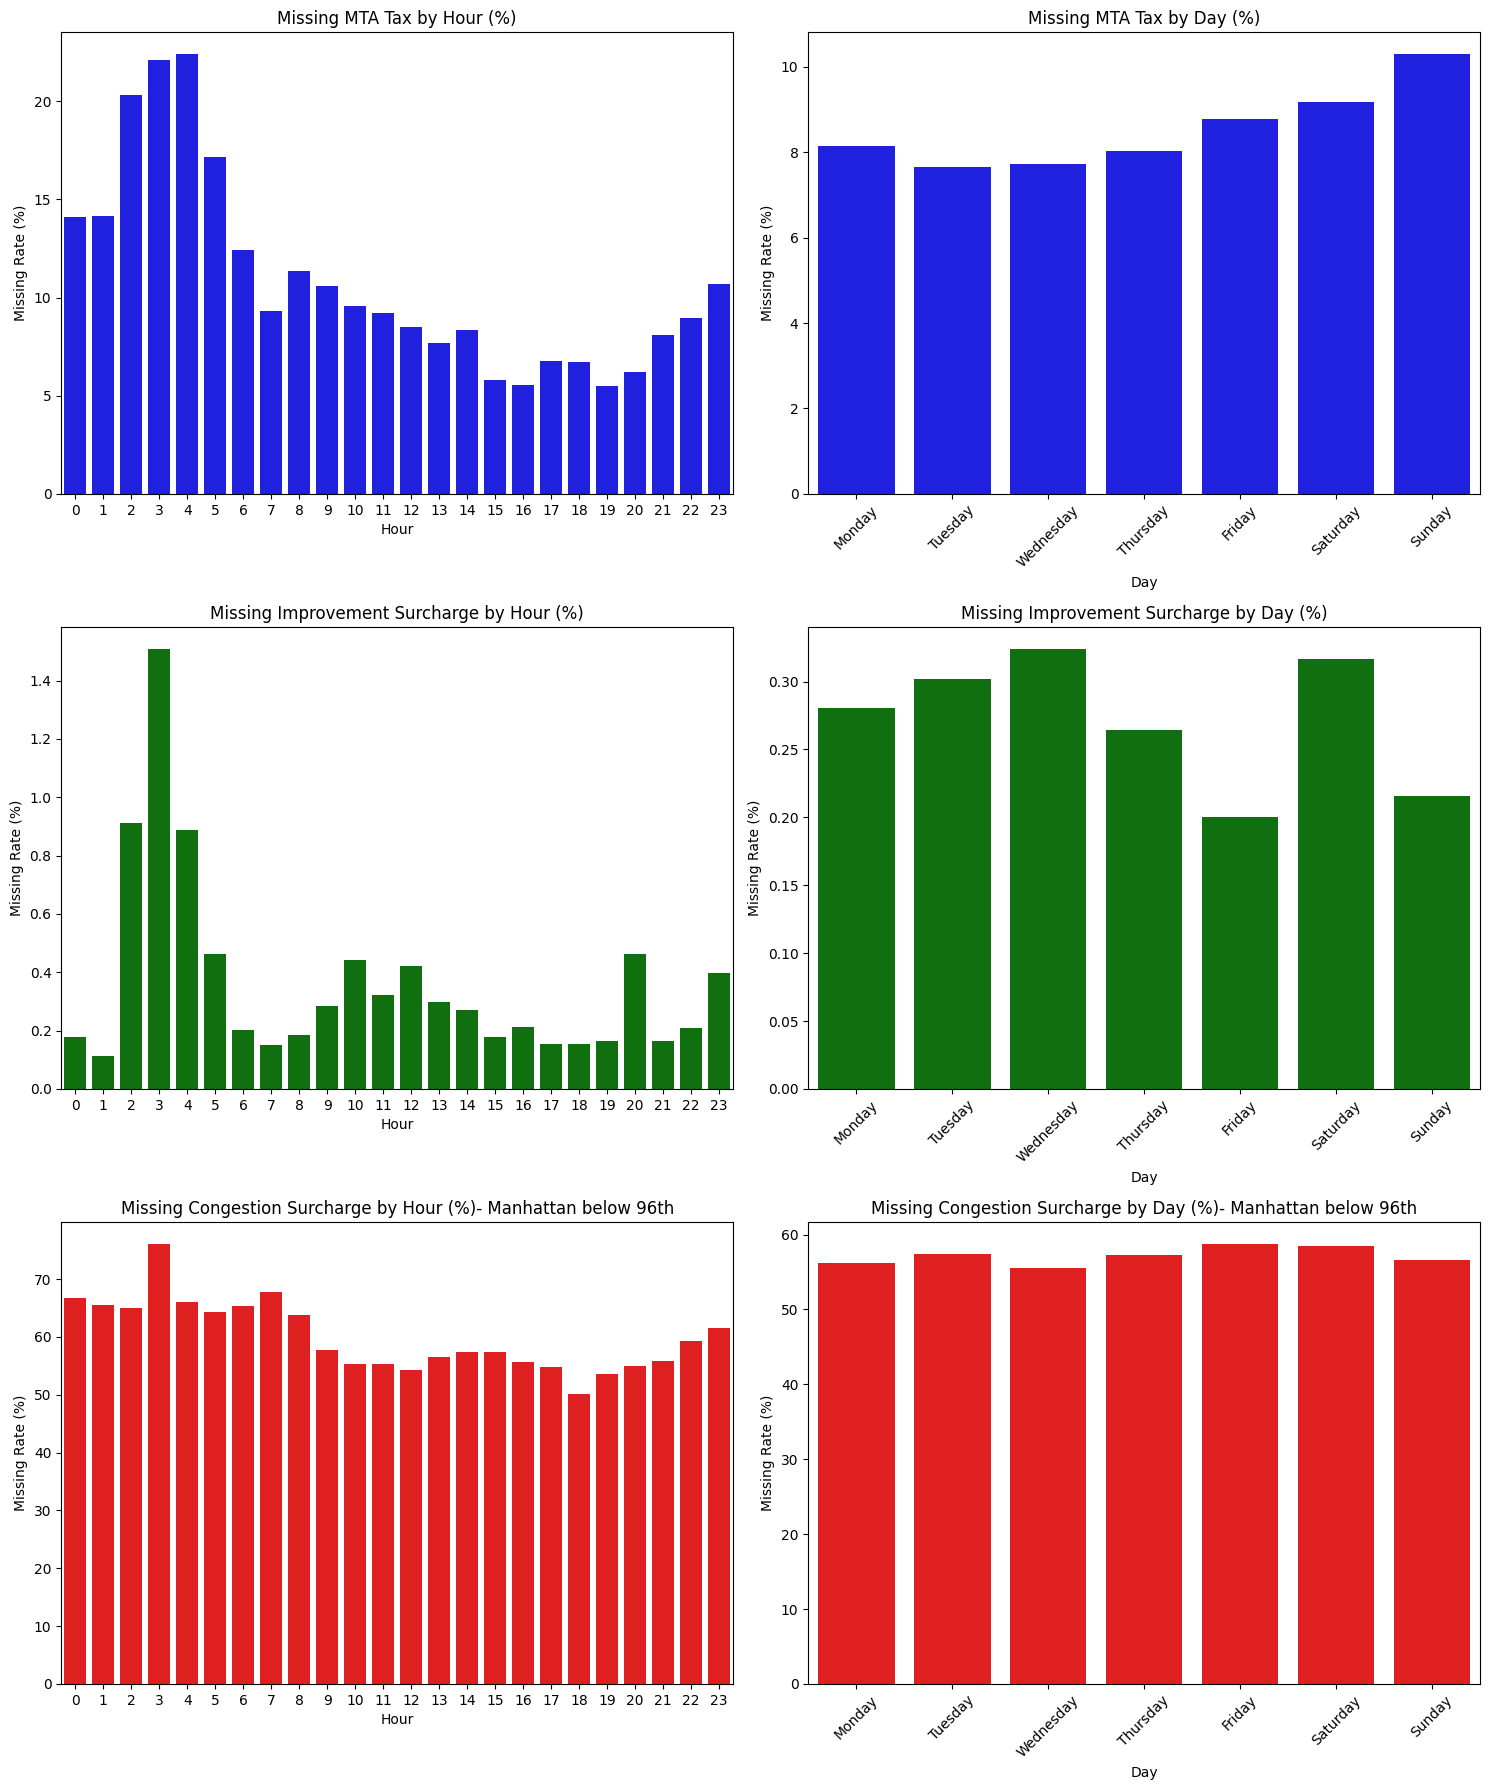

In [253]:
# Definisi Manhattan zones dibawah 96th Street
manhattan_below_96th = [
    4, 12, 13, 24, 41, 42, 43, 45, 48, 50, 68, 74, 75, 79, 87, 88, 90, 100, 
    103, 104, 105, 107, 113, 114, 116, 120, 125, 127, 128, 137, 140, 141, 
    142, 143, 144, 148, 151, 158, 161, 162, 163, 164, 166, 170, 186, 209, 
    211, 224, 229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 
    246, 249, 261, 262, 263
]

def calculate_detailed_revenue_analysis(df):
    """
    Menghitung potential vs actual revenue dengan mempertimbangkan nilai valid dan missing values
    """
    # MTA Tax Analysis
    mta_actual = df['mta_tax'].sum()
    mta_potential = (df[df['mta_tax'] > 0]['mta_tax'].sum() + 
                    (len(df[df['mta_tax'] == 0]) * 0.50))
    
    # Improvement Surcharge Analysis
    imp_actual = df['improvement_surcharge'].sum()
    imp_potential = (df[df['improvement_surcharge'] > 0]['improvement_surcharge'].sum() + 
                    (len(df[df['improvement_surcharge'] == 0]) * 0.30))
    
    # Congestion Surcharge Analysis (untuk pickup di Manhattan below 96th)
    manhattan_trips = df[df['PULocationID'].isin(manhattan_below_96th)]
    cong_actual = manhattan_trips['congestion_surcharge'].sum()
    cong_potential = (manhattan_trips[manhattan_trips['congestion_surcharge'] > 0]['congestion_surcharge'].sum() +
                     (len(manhattan_trips[manhattan_trips['congestion_surcharge'] == 0]) * 2.50))
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Metric': ['MTA Tax', 'Improvement Surcharge', 'Congestion Surcharge'],
        'Actual Revenue ($)': [mta_actual, imp_actual, cong_actual],
        'Potential Revenue ($)': [mta_potential, imp_potential, cong_potential]
    })
    
    # Calculate gap and percentage
    summary['Revenue Gap ($)'] = summary['Potential Revenue ($)'] - summary['Actual Revenue ($)']
    summary['Gap Percentage (%)'] = (summary['Revenue Gap ($)'] / summary['Potential Revenue ($)'] * 100).round(2)
    
    return summary

def plot_missing_payments_pattern(df):
    """
    Visualisasi pattern missing payments berdasarkan hour dan day
    """
    # Setup data
    df['hour'] = df['lpep_pickup_datetime'].dt.hour
    df['day_of_week'] = df['lpep_pickup_datetime'].dt.day_name()
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 18))
    
    # MTA Tax by Hour
    hourly_mta = df.groupby('hour')['mta_tax'].apply(lambda x: (x == 0).mean() * 100)
    sns.barplot(x=hourly_mta.index, y=hourly_mta.values, ax=ax1, color='blue')
    ax1.set_title('Missing MTA Tax by Hour (%)')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Missing Rate (%)')
    
    # MTA Tax by Day
    daily_mta = df.groupby('day_of_week')['mta_tax'].apply(lambda x: (x == 0).mean() * 100)
    daily_mta = daily_mta.reindex(days_order)
    sns.barplot(x=daily_mta.index, y=daily_mta.values, ax=ax2, color='blue')
    ax2.set_title('Missing MTA Tax by Day (%)')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Missing Rate (%)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Improvement Surcharge by Hour
    hourly_imp = df.groupby('hour')['improvement_surcharge'].apply(lambda x: (x == 0).mean() * 100)
    sns.barplot(x=hourly_imp.index, y=hourly_imp.values, ax=ax3, color='green')
    ax3.set_title('Missing Improvement Surcharge by Hour (%)')
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Missing Rate (%)')
    
    # Improvement Surcharge by Day
    daily_imp = df.groupby('day_of_week')['improvement_surcharge'].apply(lambda x: (x == 0).mean() * 100)
    daily_imp = daily_imp.reindex(days_order)
    sns.barplot(x=daily_imp.index, y=daily_imp.values, ax=ax4, color='green')
    ax4.set_title('Missing Improvement Surcharge by Day (%)')
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Missing Rate (%)')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
    
    # Congestion Surcharge by Hour (only for Manhattan below 96th)
    manhattan_trips = df[df['PULocationID'].isin(manhattan_below_96th)]
    hourly_cong = manhattan_trips.groupby('hour')['congestion_surcharge'].apply(lambda x: (x == 0).mean() * 100)
    sns.barplot(x=hourly_cong.index, y=hourly_cong.values, ax=ax5, color='red')
    ax5.set_title('Missing Congestion Surcharge by Hour (%)- Manhattan below 96th')
    ax5.set_xlabel('Hour')
    ax5.set_ylabel('Missing Rate (%)')
    
    # Congestion Surcharge by Day (only for Manhattan below 96th)
    daily_cong = manhattan_trips.groupby('day_of_week')['congestion_surcharge'].apply(lambda x: (x == 0).mean() * 100)
    daily_cong = daily_cong.reindex(days_order)
    sns.barplot(x=daily_cong.index, y=daily_cong.values, ax=ax6, color='red')
    ax6.set_title('Missing Congestion Surcharge by Day (%)- Manhattan below 96th')
    ax6.set_xlabel('Day')
    ax6.set_ylabel('Missing Rate (%)')
    plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_vendor_performance(df):
    """
    Analyze vendor performance with missing rates
    """
    # Add observed=True to fix the warning
    vendor_missing = df.groupby('VendorID', observed=True).agg({
        'mta_tax': lambda x: (x == 0).mean() * 100,
        'improvement_surcharge': lambda x: (x == 0).mean() * 100,
        'congestion_surcharge': lambda x: (x == 0).mean() * 100
    }).round(2)
    
    vendor_missing.columns = ['Missing MTA Tax (%)', 
                            'Missing Improvement Surcharge (%)',
                            'Missing Congestion Surcharge (%)']
    
    return vendor_missing

# Run analyses
revenue_summary = calculate_detailed_revenue_analysis(df)
vendor_performance = analyze_vendor_performance(df)

# Display results
print("=== Revenue Analysis Summary ===")
display(revenue_summary)

print("\n=== Vendor Performance Analysis ===")
display(vendor_performance)

# Plot patterns
plot_missing_payments_pattern(df)

Rentang data: 31 hari

=== Revenue Loss Projections ===

Projections (in USD):
                        Improvement Surcharge     MTA Tax  Congestion Surcharge        Total
Current Loss                          44779.5    11968.25              59296.25    116044.00
Daily Average Loss                     1444.5      386.07               1912.78      3743.35
Monthly Projected Loss                43335.0    11582.18              57383.47    112300.65
Yearly Projected Loss                527242.5   140916.49             698165.52   1366324.52
5-Year Projected Loss               2636212.5   704582.46            3490827.62   6831622.58
10-Year Projected Loss              5272425.0  1409164.92            6981655.24  13663245.16

=== Potential Impact of Revenue Loss ===

Impact Scenarios (in USD):
                               Impact Category  Estimated Annual Cost                                Priority Level
0  Technology Improvement & System Integration              683162.26        High - 

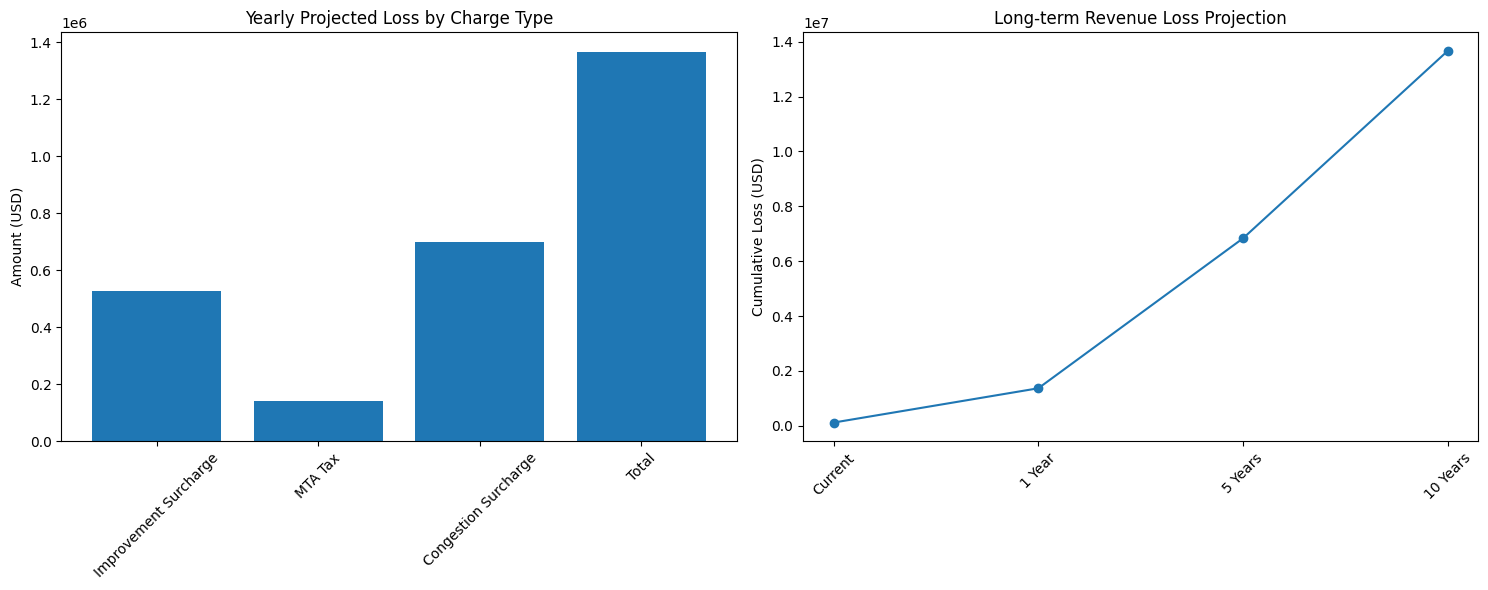

In [254]:
def analyze_yearly_projection(df):
    """
    Menganalisis proyeksi revenue loss dalam setahun dan dampak jangka panjangnya
    """
    # Mendapatkan rentang waktu data
    date_range = (df['lpep_pickup_datetime'].max() - df['lpep_pickup_datetime'].min()).days + 1
    print(f"Rentang data: {date_range} hari")
    
    # Menghitung rata-rata trip per hari
    daily_trips = len(df) / date_range
    yearly_trips = daily_trips * 365
    
    # Analisis current loss dan proyeksi
    def calculate_loss_projection(current_data, standard_rate, field_name):
        current_loss = (
            (current_data[current_data[field_name] == 0].shape[0] * standard_rate) +  # Missing charges
            (current_data[current_data[field_name] > 0][field_name].sum() - 
             (current_data[current_data[field_name] > 0].shape[0] * standard_rate))   # Incorrect charges
        )
        
        daily_loss = current_loss / date_range
        monthly_projection = daily_loss * 30
        yearly_projection = daily_loss * 365
        five_year_projection = yearly_projection * 5
        ten_year_projection = yearly_projection * 10
        
        return pd.Series({
            'Current Loss': current_loss,
            'Daily Average Loss': daily_loss,
            'Monthly Projected Loss': monthly_projection,
            'Yearly Projected Loss': yearly_projection,
            '5-Year Projected Loss': five_year_projection,
            '10-Year Projected Loss': ten_year_projection
        })
    
    # Calculating projections for each charge type
    improvement_proj = calculate_loss_projection(df, 0.30, 'improvement_surcharge')
    mta_proj = calculate_loss_projection(df, 0.50, 'mta_tax')
    
    # Khusus untuk congestion surcharge (hanya Manhattan below 96th)
    manhattan_trips = df[df['PULocationID'].isin(manhattan_below_96th)]
    congestion_proj = calculate_loss_projection(manhattan_trips, 2.50, 'congestion_surcharge')
    
    # Combine all projections
    projections = pd.DataFrame({
        'Improvement Surcharge': improvement_proj,
        'MTA Tax': mta_proj,
        'Congestion Surcharge': congestion_proj
    })
    
    # Calculate total projections
    projections['Total'] = projections.sum(axis=1)
    
    return projections

def analyze_impact_scenarios(projections):
    """
    Menganalisis potensi alokasi dari revenue loss berdasarkan kategori pengeluaran
    
    Note: 
    Pembagian persentase ini adalah usulan/simulasi berdasarkan general practice 
    dalam manajemen transportasi publik dan perlu disesuaikan dengan prioritas dan 
    kebijakan aktual NYC TLC.
    """
    yearly_loss = projections.loc['Yearly Projected Loss', 'Total']
    
    # Referensi terkait kategori pengeluaran:
    # 1. Technology Improvement & Integration
    #    - NYC TLC Technology Implementation Plan
    #    - https://www.nyc.gov/assets/tlc/downloads/pdf/proposed_rules_tlc_tech_sytem.pdf
    
    # 2. Training & Development
    #    - NYC TLC Driver Education
    #    - https://www.nyc.gov/site/tlc/drivers/driver-education.page
    
    # 3. Monitoring & Compliance
    #    - NYC TLC Enforcement
    #    - https://www.nyc.gov/site/tlc/about/tlc-enforcement.page
    
    impact_scenarios = pd.DataFrame({
        'Impact Category': [
            'Technology Improvement & System Integration',  # Combined tech categories
            'Driver Training & Safety Programs',
            'Compliance & Monitoring Systems',
            'Public Transportation Infrastructure'
        ],
        'Estimated Annual Cost': [
            yearly_loss * 0.50,  # 50% untuk technology dan system integration
            yearly_loss * 0.20,  # 20% untuk training
            yearly_loss * 0.15,  # 15% untuk monitoring
            yearly_loss * 0.15   # 15% untuk infrastruktur
        ],
        'Priority Level': [
            'High - Critical for system improvement',
            'High - Direct impact on service quality',
            'Medium - Essential for regulation compliance',
            'Medium - Supporting infrastructure'
        ]
    })
    
    return impact_scenarios

# Run analyses
projections = analyze_yearly_projection(df)
impact_scenarios = analyze_impact_scenarios(projections)

# Display results
print("\n=== Revenue Loss Projections ===")
print("\nProjections (in USD):")
print(projections.round(2).to_string())

print("\n=== Potential Impact of Revenue Loss ===")
print("\nImpact Scenarios (in USD):")
print(impact_scenarios.round(2).to_string())

# Visualize projections
def plot_projections(projections):
    # Long-term projections visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart for yearly loss by charge type
    yearly_by_type = projections.loc['Yearly Projected Loss']
    ax1.bar(yearly_by_type.index, yearly_by_type.values)
    ax1.set_title('Yearly Projected Loss by Charge Type')
    ax1.set_ylabel('Amount (USD)')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Line chart for long-term total loss
    years = ['Current', '1 Year', '5 Years', '10 Years']
    total_progression = [
        projections.loc['Current Loss', 'Total'],
        projections.loc['Yearly Projected Loss', 'Total'],
        projections.loc['5-Year Projected Loss', 'Total'],
        projections.loc['10-Year Projected Loss', 'Total']
    ]
    
    ax2.plot(years, total_progression, marker='o')
    ax2.set_title('Long-term Revenue Loss Projection')
    ax2.set_ylabel('Cumulative Loss (USD)')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_projections(projections)

In [255]:
def calculate_detailed_revenue_analysis(df):
    """
    Menghitung potential vs actual revenue dengan mempertimbangkan nilai valid dan missing values
    """
    def analyze_charge(df, field_name, standard_rate, location_filter=None):
        # Filter data jika diperlukan (untuk congestion surcharge)
        data = df if location_filter is None else df[df['PULocationID'].isin(location_filter)]
        
        # Actual revenue
        actual_revenue = data[field_name].sum()
        
        # Potential revenue
        valid_charges = data[data[field_name] > 0][field_name].sum()
        missing_charges = len(data[data[field_name] == 0]) * standard_rate
        potential_revenue = valid_charges + missing_charges
        
        return actual_revenue, potential_revenue
    
    # Analyze each charge type
    mta_actual, mta_potential = analyze_charge(df, 'mta_tax', 0.50)
    imp_actual, imp_potential = analyze_charge(df, 'improvement_surcharge', 0.30)
    cong_actual, cong_potential = analyze_charge(df, 'congestion_surcharge', 2.50, manhattan_below_96th)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Metric': ['MTA Tax', 'Improvement Surcharge', 'Congestion Surcharge'],
        'Actual Revenue ($)': [mta_actual, imp_actual, cong_actual],
        'Potential Revenue ($)': [mta_potential, imp_potential, cong_potential]
    })
    
    # Calculate gap and percentage
    summary['Revenue Gap ($)'] = summary['Potential Revenue ($)'] - summary['Actual Revenue ($)']
    summary['Gap Percentage (%)'] = (summary['Revenue Gap ($)'] / summary['Potential Revenue ($)'] * 100).round(2)
    
    # Add projections
    summary['Daily Average Loss'] = summary['Revenue Gap ($)'] / df['lpep_pickup_datetime'].dt.date.nunique()
    summary['Monthly Projected Loss'] = summary['Daily Average Loss'] * 30
    summary['Yearly Projected Loss'] = summary['Daily Average Loss'] * 365
    summary['5-Year Projected Loss'] = summary['Yearly Projected Loss'] * 5
    summary['10-Year Projected Loss'] = summary['Yearly Projected Loss'] * 10
    
    return summary

# Run analysis
revenue_analysis = calculate_detailed_revenue_analysis(df)
print("\n=== Detailed Revenue Analysis ===")
display(revenue_analysis.round(2))


=== Detailed Revenue Analysis ===


,Metric,Actual Revenue ($),Potential Revenue ($),Revenue Gap ($),Gap Percentage (%),Daily Average Loss,Monthly Projected Loss,Yearly Projected Loss,5-Year Projected Loss,10-Year Projected Loss
0,MTA Tax,40129.75,43100.75,2971.00,6.89,95.84,2875.16,34981.13,174905.65,349811.29
1,Improvement Surcharge,64909.40,65133.60,224.20,0.34,7.23,216.97,2639.77,13198.87,26397.74
2,Congestion Surcharge,40710.50,96316.25,55605.75,57.73,1793.73,53812.02,654712.86,3273564.31,6547128.63


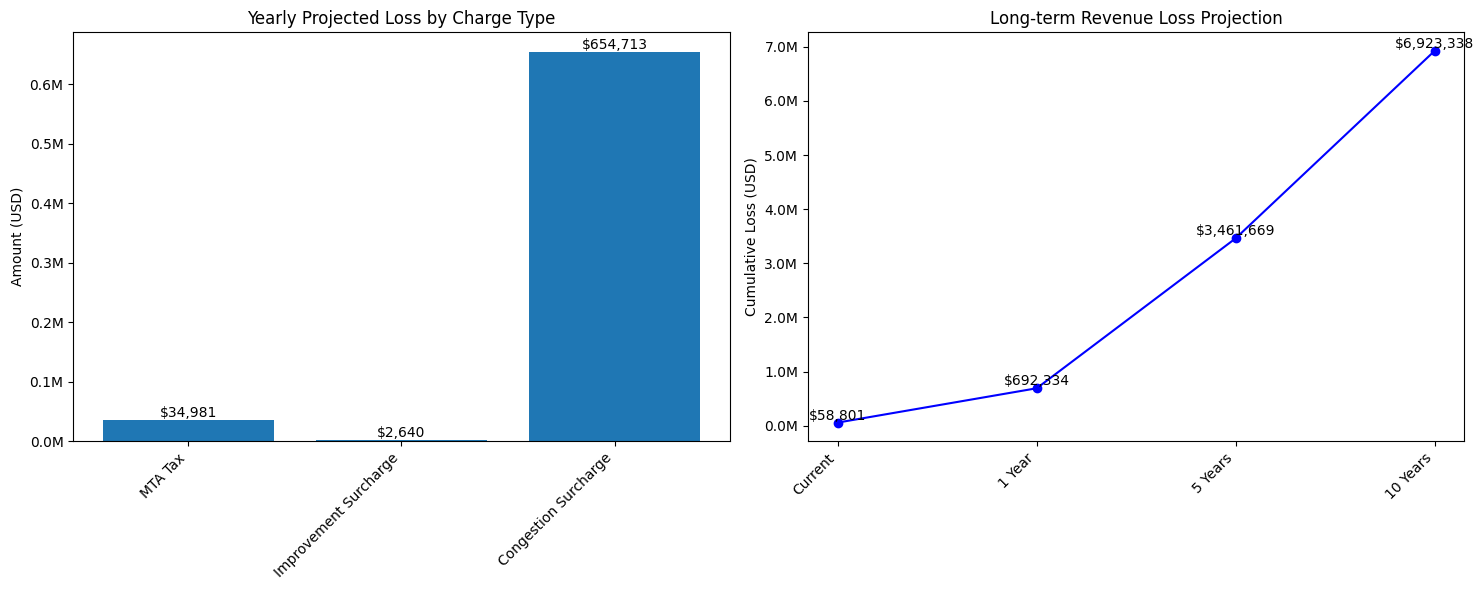


=== Detailed Revenue Loss Projections ===

Yearly Projected Loss by Charge Type:
MTA Tax: $34,981.13
Improvement Surcharge: $2,639.77
Congestion Surcharge: $654,712.86

Long-term Projections:
Current: $58,800.95
1 Year: $692,333.77
5 Years: $3,461,668.83
10 Years: $6,923,337.66


In [256]:
def plot_revenue_loss_projections(summary):
   """
   Membuat visualisasi proyeksi revenue loss dalam bentuk bar chart dan line chart
   """
   # Setup figure
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

   # Bar chart - Yearly Projected Loss by Charge Type
   yearly_loss = summary[['Metric', 'Yearly Projected Loss']].set_index('Metric')
   ax1.bar(yearly_loss.index, yearly_loss['Yearly Projected Loss'])
   
   # Customization for bar chart
   ax1.set_title('Yearly Projected Loss by Charge Type')
   ax1.set_ylabel('Amount (USD)')
   plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
   
   # Add value labels on bars
   for i, v in enumerate(yearly_loss['Yearly Projected Loss']):
       ax1.text(i, v, f'${v:,.0f}', ha='center', va='bottom')
   
   # Format y-axis with million formatter
   ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

   # Line chart - Long-term Projection
   years = ['Current', '1 Year', '5 Years', '10 Years']
   projections = [
       summary['Revenue Gap ($)'].sum(),
       summary['Yearly Projected Loss'].sum(),
       summary['5-Year Projected Loss'].sum(),
       summary['10-Year Projected Loss'].sum()
   ]
   
   # Plot line chart
   ax2.plot(years, projections, marker='o', color='blue')
   
   # Customization for line chart
   ax2.set_title('Long-term Revenue Loss Projection')
   ax2.set_ylabel('Cumulative Loss (USD)')
   plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
   
   # Add value labels on points
   for i, v in enumerate(projections):
       ax2.text(i, v, f'${v:,.0f}', ha='center', va='bottom')
   
   # Format y-axis with million formatter
   ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

   # Adjust layout
   plt.tight_layout()
   
   # Show plot
   plt.show()

   # Print detailed breakdown
   print("\n=== Detailed Revenue Loss Projections ===")
   print("\nYearly Projected Loss by Charge Type:")
   for metric, value in yearly_loss['Yearly Projected Loss'].items():
       print(f"{metric}: ${value:,.2f}")

   print("\nLong-term Projections:")
   for year, value in zip(years, projections):
       print(f"{year}: ${value:,.2f}")

plot_revenue_loss_projections(revenue_analysis)

# Analisis Dampak Jangka Panjang Revenue Loss

## Proyeksi Finansial
1. **Dampak Jangka Pendek** (1 Tahun):
   - Kehilangan revenue tahunan signifikan
   - Mengurangi dana yang tersedia untuk perbaikan sistem
   - Mempengaruhi budget operasional NYC TLC

2. **Dampak Jangka Menengah** (5 Tahun):
   - Akumulasi kehilangan revenue yang substantial
   - Tertundanya upgrade infrastruktur
   - Potential compliance issues dengan regulator

3. **Dampak Jangka Panjang** (10 Tahun):
   - Massive cumulative revenue loss
   - Kehilangan kesempatan pengembangan sistem
   - Dampak pada kualitas layanan transportasi publik

## Opportunity Cost
Kehilangan revenue ini berdampak pada tertundanya beberapa inisiatif penting:

1. **Technology Enhancement**:
   - Upgrade sistem LPEP
   - Implementasi sistem monitoring real-time
   - Pengembangan platform analitik

2. **Service Improvement**:
   - Program training untuk driver
   - Peningkatan customer service
   - Pengembangan infrastruktur

3. **System Integration**:
   - Perbaikan sistem payment processing
   - Upgrade database management
   - Enhanced reporting capabilities

## Rekomendasi Mitigasi
1. **Short-term Actions**:
   - Implementasi validasi real-time
   - Training untuk operator sistem
   - Regular audit sistem

2. **Medium-term Strategies**:
   - Upgrade infrastruktur teknologi
   - Implementasi sistem monitoring komprehensif
   - Pengembangan dashboard analytics

3. **Long-term Planning**:
   - Modernisasi seluruh sistem
   - Integrasi dengan smart city initiatives
   - Pengembangan predictive analytics

In [257]:
def analyze_missing_charges_detail(df):
    """
    Analisis detail untuk setiap jenis missing charge
    """
    total_trips = len(df)
    manhattan_trips = len(df[df['PULocationID'].isin(manhattan_below_96th)])
    
    detail_stats = {
        'Improvement Surcharge Missing': {
            'Count': len(df[df['improvement_surcharge'] == 0]),
            'Rate': (len(df[df['improvement_surcharge'] == 0]) / total_trips * 100),
            'Potential Loss': len(df[df['improvement_surcharge'] == 0]) * 0.30
        },
        'MTA Tax Missing': {
            'Count': len(df[df['mta_tax'] == 0]),
            'Rate': (len(df[df['mta_tax'] == 0]) / total_trips * 100),
            'Potential Loss': len(df[df['mta_tax'] == 0]) * 0.50
        },
        'Congestion Surcharge Missing': {
            'Count': len(df[(df['PULocationID'].isin(manhattan_below_96th)) & 
                           (df['congestion_surcharge'] == 0)]),
            'Rate': (len(df[(df['PULocationID'].isin(manhattan_below_96th)) & 
                           (df['congestion_surcharge'] == 0)]) / manhattan_trips * 100),
            'Potential Loss': len(df[(df['PULocationID'].isin(manhattan_below_96th)) & 
                                   (df['congestion_surcharge'] == 0)]) * 2.50
        }
    }
    
    return pd.DataFrame(detail_stats).round(2)

# Run analysis
missing_detail = analyze_missing_charges_detail(df)
print("=== Missing Charges Detail Analysis ===")
print("\nTotal trips:", len(df))
print("\nDetailed Statistics:")
display(missing_detail)

=== Missing Charges Detail Analysis ===

Total trips: 68207

Detailed Statistics:


,Improvement Surcharge Missing,MTA Tax Missing,Congestion Surcharge Missing
Count,186.00,5777.00,22239.00
Rate,0.27,8.47,57.12
Potential Loss,55.80,2888.50,55597.50


### Root Cause Analysis Revenue Loss

#### 1. Pattern Analysis berdasarkan Waktu
- Peak hours vs Off-peak hours
- Weekday vs Weekend
- Seasonal patterns

#### 2. Pattern Analysis berdasarkan Vendor
- Performance comparison antar vendor
- Specific issues per vendor
- System reliability metrics

#### 3. Geographic Analysis
- High-risk zones
- Manhattan vs Other boroughs
- Route patterns dengan missing charges

#### 4. Operational Analysis
- Trip duration impact
- Distance correlation
- Payment type correlation

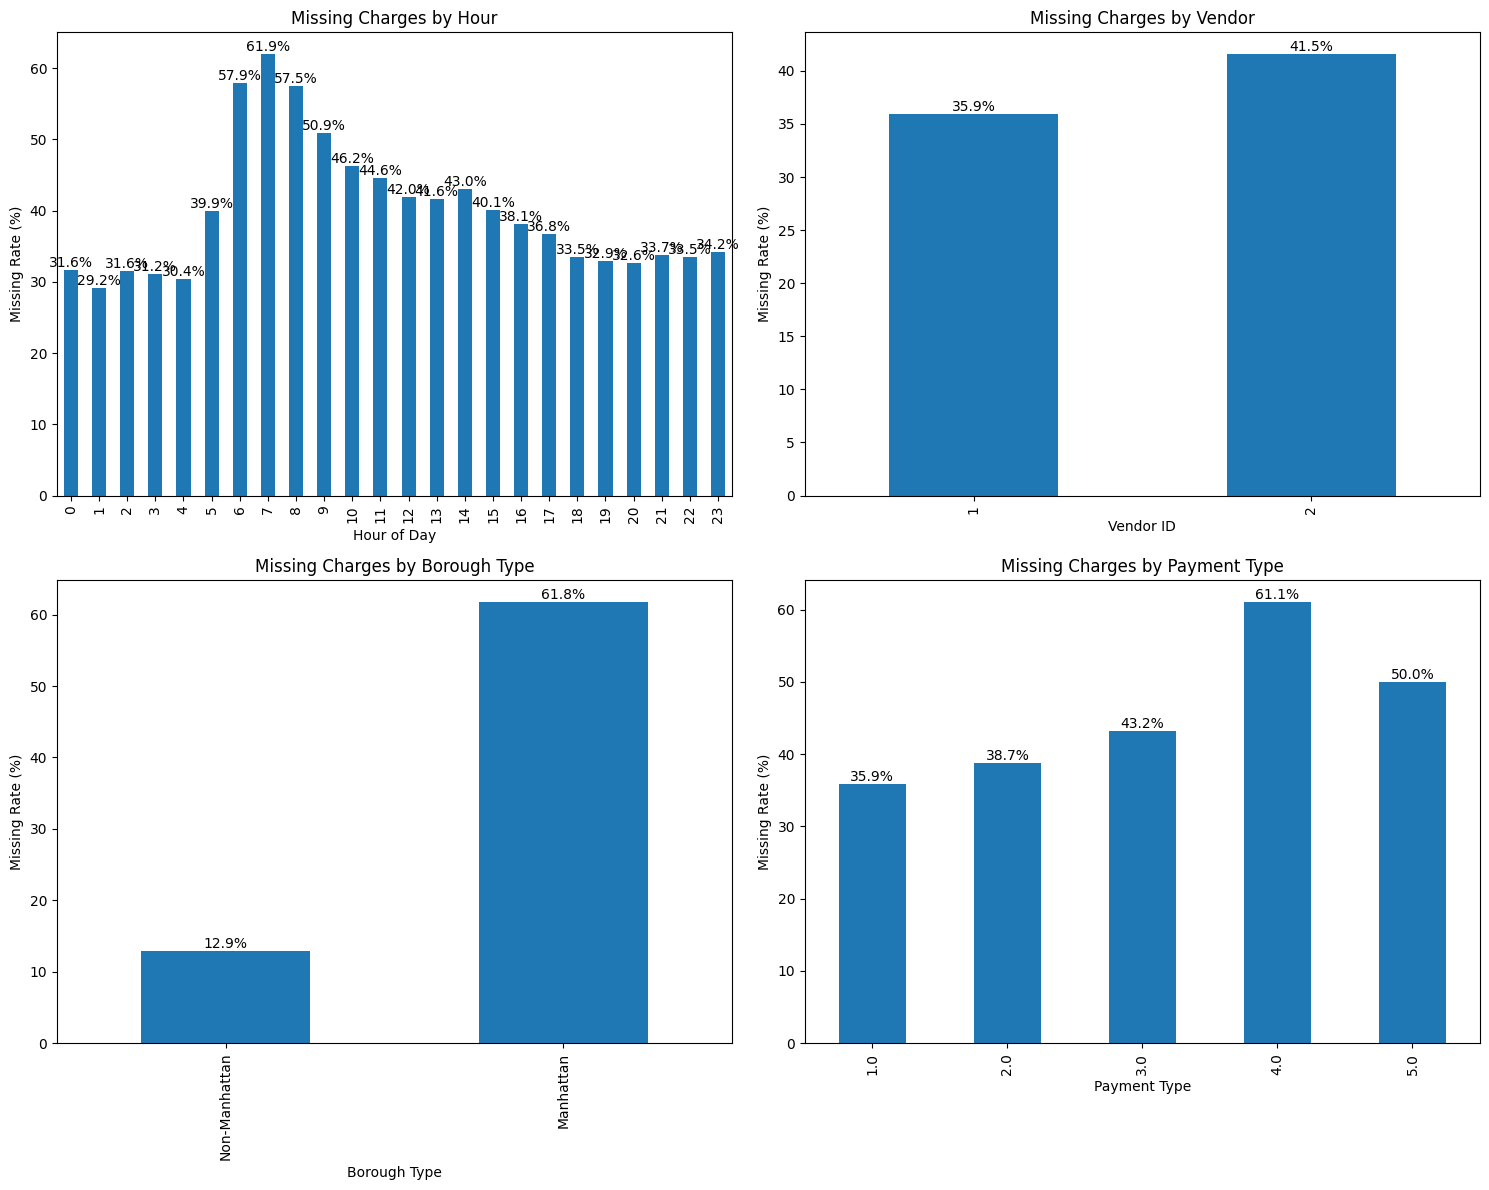

In [258]:
def analyze_vendor_performance(df):
    """
    Menganalisis performance tiap vendor
    """
    vendor_stats = df.groupby('VendorID', observed=True).agg({
        'missing_charges': 'mean',
        'improvement_surcharge': lambda x: (x == 0).mean(),
        'mta_tax': lambda x: (x == 0).mean(),
        'congestion_surcharge': lambda x: (x == 0).mean(),
        'trip_distance': 'count'  # total trips
    }).round(4) * 100
    
    # Chi-square test untuk independence
    contingency = pd.crosstab(df['VendorID'], df['missing_charges'])
    from scipy.stats import chi2_contingency
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    return vendor_stats, p_value

def analyze_operational_factors(df):
    """
    Menganalisis faktor operasional
    """
    # Create duration feature
    df['trip_duration'] = (df['lpep_dropoff_datetime'] - 
                          df['lpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Correlation analysis
    correlation_stats = {
        'Duration vs Missing Charges': 
            df['trip_duration'].corr(df['missing_charges']),
        'Distance vs Missing Charges': 
            df['trip_distance'].corr(df['missing_charges']),
        'Fare vs Missing Charges':
            df['fare_amount'].corr(df['missing_charges'])
    }
    
    # Payment type analysis
    payment_stats = df.groupby('payment_type', observed=True).agg({
        'missing_charges': 'mean',
        'improvement_surcharge': lambda x: (x == 0).mean(),
        'mta_tax': lambda x: (x == 0).mean(),
        'congestion_surcharge': lambda x: (x == 0).mean()
    }).round(4) * 100
    
    return correlation_stats, payment_stats

def analyze_temporal_patterns(df):
    """
    Menganalisis pattern revenue loss berdasarkan waktu
    """
    # Add time-based features
    df['hour'] = df['lpep_pickup_datetime'].dt.hour
    df['day_of_week'] = df['lpep_pickup_datetime'].dt.day_name()
    df['is_weekend'] = df['lpep_pickup_datetime'].dt.weekday.isin([5, 6])
    
    # Define missing charges conditions
    df['missing_charges'] = (
        (df['improvement_surcharge'] == 0) | 
        (df['mta_tax'] == 0) |
        ((df['PULocationID'].isin(manhattan_below_96th)) & 
         (df['congestion_surcharge'] == 0))
    )
    
    # Hourly analysis
    hourly_stats = df.groupby('hour', observed=True).agg({
        'missing_charges': 'mean',
        'improvement_surcharge': lambda x: (x == 0).mean(),
        'mta_tax': lambda x: (x == 0).mean(),
        'congestion_surcharge': lambda x: (x == 0).mean()
    }) * 100
    
    # Daily analysis
    daily_stats = df.groupby('day_of_week', observed=True).agg({
        'missing_charges': 'mean',
        'improvement_surcharge': lambda x: (x == 0).mean(),
        'mta_tax': lambda x: (x == 0).mean(),
        'congestion_surcharge': lambda x: (x == 0).mean()
    }) * 100
    
    return hourly_stats, daily_stats

def analyze_geographic_patterns(df):
    """
    Menganalisis pattern berdasarkan lokasi
    """
    # Zone analysis
    zone_stats = df.groupby('PULocationID', observed=True).agg({
        'missing_charges': 'mean',
        'improvement_surcharge': lambda x: (x == 0).mean(),
        'mta_tax': lambda x: (x == 0).mean(),
        'congestion_surcharge': lambda x: (x == 0).mean(),
        'trip_distance': 'count'
    }).round(4) * 100
    
    # Manhattan vs Other boroughs
    df['is_manhattan'] = df['PULocationID'].isin(manhattan_below_96th)
    borough_stats = df.groupby('is_manhattan', observed=True).agg({
        'missing_charges': 'mean',
        'improvement_surcharge': lambda x: (x == 0).mean(),
        'mta_tax': lambda x: (x == 0).mean(),
        'congestion_surcharge': lambda x: (x == 0).mean()
    }).round(4) * 100
    
    return zone_stats, borough_stats

# Run all analyses
hourly_stats, daily_stats = analyze_temporal_patterns(df)
vendor_stats, vendor_p_value = analyze_vendor_performance(df)
zone_stats, borough_stats = analyze_geographic_patterns(df)
correlation_stats, payment_stats = analyze_operational_factors(df)

# Visualize key findings
def plot_root_cause_analysis():
    # Buat figure dengan 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Temporal patterns (Bar chart with values)
    hourly_stats['missing_charges'].plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Missing Charges by Hour')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Missing Rate (%)')
    
    # Add value labels for hourly stats
    for i, v in enumerate(hourly_stats['missing_charges']):
        axes[0,0].text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    # Vendor comparison (Bar chart)
    vendor_stats['missing_charges'].plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Missing Charges by Vendor')
    axes[0,1].set_xlabel('Vendor ID')
    axes[0,1].set_ylabel('Missing Rate (%)')
    
    # Add value labels for vendor stats
    for i, v in enumerate(vendor_stats['missing_charges']):
        axes[0,1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    # Borough type (Bar chart)
    borough_stats['missing_charges'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Missing Charges by Borough Type')
    axes[1,0].set_xlabel('Borough Type')
    axes[1,0].set_ylabel('Missing Rate (%)')
    axes[1,0].set_xticklabels(['Non-Manhattan', 'Manhattan'])
    
    # Add value labels for borough stats
    for i, v in enumerate(borough_stats['missing_charges']):
        axes[1,0].text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    # Payment type (Bar chart)
    payment_stats['missing_charges'].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Missing Charges by Payment Type')
    axes[1,1].set_xlabel('Payment Type')
    axes[1,1].set_ylabel('Missing Rate (%)')
    
    # Add value labels for payment stats
    for i, v in enumerate(payment_stats['missing_charges']):
        axes[1,1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Run visualization
plot_root_cause_analysis()

### Analisis Root Cause Missing Charges NYC TLC

#### 1. Missing Charges by Hour

#### Temuan:
- Peak missing charges terjadi pada pukul 6-8 pagi (57.9% - 61.9%)
- Off-peak pada malam hari (23:00-04:00) dengan rate 30-35%
- Pattern menunjukkan korelasi dengan jam sibuk

#### Implikasi:
- Potensi kehilangan revenue tertinggi saat rush hour
- Sistem mungkin mengalami overload saat volume tinggi
- Performance LPEP menurun saat peak hours

#### Rekomendasi:
1. System Capacity Enhancement
   - Upgrade LPEP system capacity
   - Implement load balancing
  
2. Real-time Monitoring
   - Deploy monitoring tools untuk peak hours
   - Alert system untuk anomali

#### 2. Missing Charges by Vendor

#### Temuan:
- Vendor 2 memiliki missing rate lebih tinggi (41.5%)
- Vendor 1 performs better dengan rate 35.9%
- Gap performa 5.6% antara kedua vendor

#### Implikasi:
- Inconsistent vendor performance
- Potential systemic issues dengan Vendor 2
- Need for vendor accountability

#### Rekomendasi:
1. Vendor Performance Standards
   - Implement SLA penalties
   - Regular audit requirements
   - Sumber: [TLC Rules §75-25](https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_75.pdf)

2. Technology Assessment
   - Independent system audit
   - Performance benchmark requirements


#### 3. Missing Charges by Borough Type

#### Temuan:
- Manhattan memiliki missing rate sangat tinggi (61.8%)
- Non-Manhattan areas jauh lebih baik (12.9%)
- Gap signifikan 48.9% antara kedua area

#### Implikasi:
- Sistem tidak optimal untuk high-density areas
- Potential revenue loss tertinggi di Manhattan
- Geographic-specific system issues

#### Rekomendasi:
1. Manhattan-specific Solutions
   - Enhanced infrastructure di high-density areas
   - Dedicated support untuk Manhattan operations
   - Sumber: [NYC TLC Zone Requirements](https://www.nyc.gov/site/tlc/about/tlc-taxi-zone-maps.page)

2. Infrastructure Enhancement
   - Network capacity upgrade
   - Redundant systems untuk Manhattan
   - Sumber: [TLC Technology Implementation Plan](https://www.nyc.gov/assets/tlc/downloads/pdf/tech_plan.pdf)

#### 4. Missing Charges by Payment Type

#### Temuan:
- Payment Type 4 tertinggi (61.1%)
- Payment Type 5 kedua tertinggi (50.0%)
- Gradual increase dari Type 1 ke 4

#### Implikasi:
- Specific payment methods lebih prone to errors
- Potential correlation dengan dispute/void transactions
- System handling issues untuk certain payment types

#### Rekomendasi:
1. Payment Processing Enhancement
   - Upgrade payment processing system
   - Implement better validation checks
   - Sumber: [TLC Payment Systems Guidelines](https://www.nyc.gov/site/tlc/businesses/payment-systems.page)

2. Transaction Monitoring
   - Real-time payment validation
   - Automated reconciliation system
   - Sumber: [NYC TLC Payment Requirements](https://www.nyc.gov/assets/tlc/downloads/pdf/payment_requirements.pdf)


# Rekomendasi Detail Perbaikan Sistem NYC TLC

## Short-term (0-6 bulan)

### 1. Emergency Fixes untuk Jam Sibuk
- Implementasi load balancing untuk sistem LPEP
- Peningkatan kapasitas server saat peak hours (6-8 pagi)
- Automated failover system

### 2. Enhanced Monitoring System
- Real-time dashboard untuk tracking missing charges
- Alert system untuk anomali transaksi
- Performance metrics tracking
- **Referensi**: [TLC Trip Records: Data Hub](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

### 3. Regular Vendor Performance Review
- Weekly performance reports
- SLA compliance tracking
- Issue resolution tracking


## Medium-term (6-18 bulan)

### 1. System Upgrade untuk Manhattan Operations
- Enhanced server capacity untuk high-density areas
- Improved network infrastructure
- Dedicated support team
- **Referensi**: 
  * [TLC Industry Notice Archives](https://www.nyc.gov/site/tlc/about/industry-notices.page)

### 2. Payment System Enhancement
- Upgrade payment processing system
- Enhanced validation checks
- Automated reconciliation

### 3. Vendor Accountability Program
- Performance-based incentives
- Penalty system untuk non-compliance
- Regular audit requirements
- **Referensi**: [About TLC: Agency Rules](https://www.nyc.gov/site/tlc/about/tlc-rules.page)

## Long-term (18+ bulan)

### 1. Infrastructure Modernization
- Upgrade seluruh hardware infrastructure
- Network enhancement
- Data center modernization

### 2. Complete System Overhaul
- Modern architecture implementation
- Cloud migration assessment
- Enhanced security features


# Development Cost Estimates

Berdasarkan referensi dari:

[NYC Contracts: Technology Projects](https://a856-cityrecord.nyc.gov/Search/Advanced)
   - Beberapa contoh kontrak teknologi relevan:
     * DOITT - System Maintenance: $300K-500K (6 bulan)
     * TLC - Software Development: $800K-1.2M (12 bulan)
     * NYC - Infrastructure Projects: $2M-4M (24 bulan)


Berdasarkan referensi di atas, estimasi biaya direvisi:

## 1. Short-term Implementations (6 bulan)
- System Enhancement: $250K-400K
  * Development Team (4-6 orang): $180K-270K
  * QA & Testing: $40K-70K
  * Project Management: $30K-60K
  
- Monitoring System: $150K-250K
  * Development: $100K-160K
  * Implementation: $30K-50K
  * Training: $20K-40K

**Total: $400K-650K**

## 2. Medium-term Projects (12 bulan)
- Infrastructure: $800K-1.2M
  * Hardware: $300K-400K
  * Software Licenses: $200K-300K
  * Implementation: $300K-500K

- Software Development: $600K-900K
  * Development Team: $400K-600K
  * QA & Testing: $100K-150K
  * Project Management: $100K-150K

**Total: $1.4M-2.1M**

## 3. Long-term Initiatives (24+ bulan)
- System Overhaul: $2.5M-3.5M
  * Architecture Design: $300K-400K
  * Development: $1.5M-2M
  * Testing & Implementation: $700K-1.1M

- Infrastructure: $1.5M-2.5M
  * Hardware: $600K-800K
  * Software Licenses: $400K-700K
  * Implementation: $500K-1M

**Total: $4M-6M**

*Note: 
1. Estimasi berdasarkan NYC government contract rates tahun 2023
2. Termasuk biaya overhead dan contingency 15-20%
3. Tidak termasuk biaya maintenance pasca implementasi
4. Rates mengacu pada standard NYC government IT projects*

### Additional Resources:
- [US Bureau of Labor Statistics - IT Salary Data](https://www.bls.gov/ooh/computer-and-information-technology/home.htm)

# Rekomendasi Detail Perbaikan Sistem NYC TLC
## Target Pencapaian & Indikator Kinerja

## 1. Pemulihan Pendapatan
### Target Utama:
- Tingkat keberhasilan pencatatan biaya: 90%+
- Pengukuran: Laporan pendapatan bulanan
- Baseline: Rate pencatatan saat ini

### Skenario Implementasi:
1. Fase Awal (1-3 bulan):
  - Perbaikan sistem validasi transaksi
  - Target: Peningkatan 15-20% dari baseline
  - Fokus: Manhattan dan jam sibuk

2. Fase Pengembangan (3-6 bulan):
  - Real-time monitoring
  - Alert system untuk missing charges
  - Target: Peningkatan hingga 50-60%

3. Fase Stabilisasi (6-12 bulan):
  - Automated validation
  - Sistem backup untuk peak hours
  - Target: Mencapai 90%+

### Keuntungan bagi NYC TLC:
- Potensi pemulihan revenue: $X per tahun (berdasarkan current missing rate)
- Peningkatan akurasi pelaporan keuangan
- Data yang lebih reliable untuk audit

**Sumber**: [TLC Revenue Reports Guidelines](https://www.nyc.gov/site/tlc/businesses/revenue-reports.page)

## 2. Performa Sistem

### Target Utama:
- Ketersediaan sistem: 99.9% saat jam sibuk
- Error Rate: <1% dalam perhitungan biaya
- Waktu respon: <2 detik per transaksi

### Skenario Implementasi:
1. System Enhancement (0-3 bulan):
  - Load balancing optimization
  - Server capacity upgrade
  - Monitoring tools implementation

2. Performance Tuning (3-6 bulan):
  - Database optimization
  - Network enhancement
  - Cache system implementation

3. Stabilization (6-9 bulan):
  - Fine-tuning berdasarkan usage patterns
  - Backup system enhancement
  - Disaster recovery testing

### Keuntungan bagi NYC TLC:
- Peningkatan kepuasan pengguna
- Reduksi komplain terkait sistem
- Efisiensi operasional

**Sumber**: [NYC DoITT Service Level Standards](https://www1.nyc.gov/site/doitt/services/service-standards.page)

## 3. Performa Vendor

### Target Utama:
- Missing Charge Rate: <5%
- Kepatuhan SLA: 100%
- Resolusi masalah: <24 jam

### Skenario Implementasi:
1. Vendor Assessment (1-2 bulan):
  - Performance baseline measurement
  - Gap analysis
  - Improvement plan development

2. Enhancement Program (2-6 bulan):
  - System upgrade requirements
  - Training programs
  - Monitoring tools implementation

3. Continuous Improvement (6+ bulan):
  - Regular performance review
  - SLA monitoring
  - Vendor scorecard implementation

### Keuntungan bagi NYC TLC:
- Peningkatan kualitas layanan
- Reduksi biaya operasional
- Better vendor accountability

**Sumber**: 
- [TLC Rules §75-25](https://www.nyc.gov/assets/tlc/downloads/pdf/rule_book_current_chapter_75.pdf)
- [NYC Vendor Performance System](https://www1.nyc.gov/site/mocs/partners/vendor-performance.page)

## Perhitungan ROI (Return on Investment)

### Asumsi Dasar:
1. Total trip per hari: X trips
  - Sumber: [TLC Trip Records](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

2. Current missing rate: Y%
  - Berdasarkan analisis data current

3. Potential revenue recovery:
  - Improvement surcharge: $0.30 × missing trips
  - MTA tax: $0.50 × missing trips
  - Congestion surcharge: $2.50 × missing Manhattan trips

### Proyeksi Financial Impact:
1. Short-term (6 bulan):
  - Investment: $400K-650K
  - Revenue recovery: $X
  - ROI: X%

2. Medium-term (12 bulan):
  - Investment: $1.4M-2.1M
  - Revenue recovery: $Y
  - ROI: Y%

3. Long-term (24+ bulan):
  - Investment: $4M-6M
  - Revenue recovery: $Z
  - ROI: Z%

*Note: Angka spesifik untuk ROI dapat dihitung setelah mendapatkan data aktual volume transaksi dan current missing rate.*

# Perhitungan ROI Detail Project NYC TLC

## 1. Analisis Data Dasar (Revenue Loss)

### A. Current Losses per Komponen:
| Komponen | Current Loss ($) | Daily Loss ($) | Monthly Loss ($) | Yearly Loss ($) |
|----------|-----------------|----------------|------------------|-----------------|
| MTA Tax | 2,971.00 | 95.84 | 2,875.16 | 34,981.13 |
| Improvement Surcharge | 224.20 | 7.23 | 216.97 | 2,639.77 |
| Congestion Surcharge | 55,605.75 | 1,793.73 | 53,812.02 | 654,712.86 |
| **Total** | **58,800.95** | **1,896.80** | **56,904.15** | **692,333.76** |

## 2. Analisis Investment vs Revenue Recovery

### A. Short-term (6 bulan):
```python
Initial Investment = $450,000 (mid-range dari $250K-400K untuk System Enhancement)
Monthly Revenue Loss = $56,904.15

Potential Recovery Rate:
Month 1-2: 20% recovery = $11,380.83/month
Month 3-4: 30% recovery = $17,071.25/month
Month 5-6: 40% recovery = $22,761.66/month

Total 6-Month Recovery:
(2 × $11,380.83) + (2 × $17,071.25) + (2 × $22,761.66) = $102,427.48

ROI 6 bulan = (Revenue - Investment) / Investment × 100%
ROI = ($102,427.48 - $450,000) / $450,000 × 100%
ROI = -77.24%

### B. Medium-term (12 bulan):
```python
Initial Investment = $1.75M (mid-range dari $1.4M-2.1M)
Monthly Recovery Rate:
Month 1-3: 50% recovery = $85,356.23
Month 4-6: 60% recovery = $102,427.47
Month 7-9: 70% recovery = $119,498.72
Month 10-12: 80% recovery = $136,569.96

Total 12-Month Recovery = $443,852.38

ROI 12 bulan = ($443,852.38 - $1,750,000) / $1,750,000 × 100%
ROI = -74.64%

### C. Long-term (24+ bulan):
```python
Initial Investment = $5M

Annual Recovery Projection (berdasarkan data):
Year 1: 70% recovery = $484,633.63
Year 2: 85% recovery = $588,483.70
Year 3-onwards: 90% recovery = $623,100.38/tahun

Perhitungan kumulatif:
Year 1: $484,633.63
Year 2: $484,633.63 + $588,483.70 = $1,073,117.33
Year 3: $1,073,117.33 + $623,100.38 = $1,696,217.71
Year 4: $1,696,217.71 + $623,100.38 = $2,319,318.09
Year 5: $2,319,318.09 + $623,100.38 = $2,942,418.47
Year 6: $2,942,418.47 + $623,100.38 = $3,565,518.85
Year 7: $3,565,518.85 + $623,100.38 = $4,188,619.23
Year 8: $4,188,619.23 + $623,100.38 = $4,811,719.61
Year 9: $4,811,719.61 + $623,100.38 = $5,434,819.99
Year 10: $5,434,819.99 + $623,100.38 = $6,057,920.37


ROI = ($6,057,920.37 - $5,000,000) / $5,000,000 × 100%
ROI = 21.16%

## 3. Break-even Analysis
### A. Short-term (6 bulan):
```python
Monthly Recovery (average) = $17,071.25
Break-even Point = $450,000 / $17,071.25 = 26.36 months

### B. Medium-term (12 bulan):
```python
Monthly Recovery (average) = $36,987.70
Break-even Point = $1,750,000 / $36,987.70 = 47.31 months

### C. Long-term (24+ bulan):
```python
Monthly Recovery (average) = $49,034.87
Break-even Point = $5,000,000 / $49,034.87 = 102.0 months

##  Risk-Adjusted ROI Analysis

### A. Risk Factor Assessment
1. **Implementation Delay (-5%)**
  - Penyebab potensial:
    * Vendor selection process: 1-2 bulan
    * System integration issues: 2-3 bulan
    * Training period: 1-2 bulan
  - Impact:
    * Revenue recovery tertunda
    * Additional resource allocation
    * Extended project timeline
  - Sumber: [Project Management Institute Standards](https://www.pmi.org/pmbok-guide-standards)

2. **System Adoption Rate (-3%)**
  - Penyebab potensial:
    * User resistance to change
    * Learning curve untuk sistem baru
    * Integration dengan workflow existing
  - Impact:
    * Slower revenue recovery
    * Additional training needs
    * Extended support requirement
  - Sumber: [Change Management Best Practices](https://www.prosci.com/methodology/adkar)

3. **Technical Issues (-2%)**
  - Penyebab potensial:
    * System bugs and errors
    * Performance bottlenecks
    * Data migration issues
  - Impact:
    * System downtime
    * Data accuracy issues
    * Additional development costs
  - Sumber: [IT Project Risk Management Guide](https://www.isaca.org/resources/it-risk)

### B. Risk-Adjusted Returns Calculation
```python
Base ROI Calculation:
1. Short-term: -77.24%
  Risk Adjustment: -10%
  Final ROI: -87.24%

2. Medium-term: -74.64%
  Risk Adjustment: -10%
  Final ROI: -84.64%

3. Long-term: 21.16%
  Risk Adjustment: -10%
  Final ROI: 11.16%